# 💖 Hybrid Quantum–Classical Neural Network: Cleveland Heart Disease Analysis

This notebook implements a **hybrid quantum-classical model** combining a **quantum neural network (QNN)** built with Qiskit and a classical neural layer in PyTorch.  
The goal is to classify clinical samples from the **UCI Cleveland Heart Disease dataset** (8 selected clinical features) to predict the presence of heart disease (Binary Classification).

### ❓ Why Hybrid?
Hybrid QNNs leverage quantum circuits as **trainable feature extractors** that map data into high-dimensional Hilbert spaces, followed by classical layers for decision-making. This architecture allows us to explore the expressivity of quantum entanglement while retaining classical optimization efficiency.

### 🛠️ Experimental Setup
Before analysis, we:
- Set up the environment (**PyTorch, Qiskit, scikit-learn, Matplotlib**).  
- Preprocess the **Cleveland dataset** (normalization, median imputation) and prepare tensors for quantum encoding.  
- Build **8-qubit quantum circuits** using `RY` (and optional `RZ`) encoding and variational layers.  
- Construct the **QNN** using `EstimatorQNN` and integrate it into the `HybridModel`.  

---

## 📊 Analysis Roadmap & Evaluation Metrics

This notebook is structured to rigorously evaluate the "explainability," performance, and stability of the hybrid model through the following comprehensive modules:

1. **Baseline Performance & Training Dynamics**
   * *Is the model learning effectively?*
   * **Training Curves:** Train loss and accuracy comparison over epochs.
   * **Test Metrics:** Test accuracy, Confusion Matrix, and full classification report (Precision, Recall, F1, Support).
   * **Stability:** Mean accuracy $\pm$ standard deviation across multiple random seeds.

2. **Global Feature Importance**
   * *Which features matter most across the entire dataset?*
   * **Global Saliency:** Saliency maps + Average Feature Saliency.
   * **Sensitivity:** Average sensitivity analysis.
   * **Consistency:** Feature importance stability across seeds and Saliency Rank Stability.

3. **Local Attribution Methods**
   * *How do we explain individual predictions?*
   * **Grad × Input:** Normalized gradient-weighted input analysis.
   * **Integrated Gradients:** Path-integral based attribution (normalized).
   * **SmoothGrad:** Noise-averaged gradient sampling for cleaner explanations.

4. **Faithfulness & Causality Tests**
   * *Do the explanations truthfully reflect the model's logic?*
   * **Deletion Metric:** Measuring performance drop when "important" features are removed.
   * **Occlusion $\Delta$-Loss:** Impact of masking specific features on the loss function.
   * **Minimum Efficacy:** The smallest subset of features required to maintain the prediction.
   * **Overreliance Risk:** Detecting if the model relies too heavily on potential artifacts.

5. **Robustness & Stability of Explanations**
   * *Are the explanations fragile?*
   * **Noise Sensitivity:** How much explanations change with slight input perturbations.
   * **Saliency Entropy:** Measuring the disorder/complexity of the saliency distribution.
   * **Saliency Sparseness:** Evaluating how focused (sparse) the explanations are.

6. **Model Behavior & Manifold Visualization**
   * *How does the model represent the data?*
   * **PCA:** Dimensionality reduction of model embeddings/outputs.
   * **Decision Surface:** Visualizing decision boundaries using the top-2 salient features.
   * **Partial Dependence:** Analyzing the marginal effect of features on the predicted outcome.

7. **Parameter & Structural Sensitivity**
   * *Which components of the quantum circuit drive predictions?*
   * **Parameter Sensitivity:** Analyzing how changes in trainable parameters $\theta$ affect the output.
   * **Cumulative $\Delta$-Loss:** Loss impact accumulated per layer/operation.
   * **Gate Knock-Out:** Ablation studies removing specific quantum gates to test structural importance.

8. **Statistical Verification**
   * *Are the observed differences statistically significant?*
   * **Wilcoxon Signed-Rank Test:** Non-parametric statistical comparison between models or encoding schemes.
---

## ⚛️ Technologies Used
- **Qiskit Machine Learning**: `EstimatorV2`, `EstimatorQNN`, `TorchConnector`  
- **PyTorch**: `nn.Module`, `BCEWithLogitsLoss`, `Adam` optimizer  
- **scikit-learn**: `StandardScaler`, `PCA`, `classification_report`  
- **AerSimulator**: High-performance local quantum simulation  

*Part of the QAMP Project: “QNNs — Saliency & Sensitivity Kit”*

## 🛠️ Experimental Setup

### 🧩 Data and PyTorch Setup

In this section, we initialize the environment by importing the core libraries necessary for building, training, and validating our hybrid model.

* **PyTorch (`torch`)**: Our primary framework for building neural network architectures and managing tensors.
* **scikit-learn**: Utilized for the **Iris dataset**, feature scaling via `StandardScaler`, and robust evaluation metrics like ROC-AUC and Confusion Matrices.
* **SciPy**: Provides the `wilcoxon` test for performing non-parametric statistical comparisons between model versions.
* **Data Handling & Viz**: **Pandas** and **NumPy** manage data structures, while **Matplotlib** handles the visual analytics of our training progress.

In [2]:
# ===== 1. Core PyTorch Modules =====
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ===== 2. Machine Learning Utilities (scikit-learn) =====
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer

# ===== 3. Statistical Analysis =====
from scipy.stats import wilcoxon
from scipy.stats import spearmanr
from scipy.stats import entropy

# ===== 4. Data Handling & Visualization =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import copy

### ⚛️ Quantum Components (Qiskit Setup)

Here we import Qiskit Machine Learning modules to build and simulate a quantum neural network (QNN). These components allow us to bridge quantum circuits with classical deep learning workflows.

* **Quantum Circuit Design**: We use `QuantumCircuit` and `Parameter` to build parameterized circuits that act as trainable quantum layers.
* **Execution & Simulation**: `AerSimulator` provides local simulation, while `EstimatorV2` (the modern primitive) handles the evaluation of circuit observables.
* **PyTorch Integration**: The `TorchConnector` is the crucial bridge, allowing a Qiskit QNN to behave like a standard `nn.Module` in PyTorch.
* **Gradient Computation**: `ParamShiftEstimatorGradient` implements the parameter-shift rule, enabling analytic gradients for quantum hardware.

In [3]:
# ===== 5. Qiskit Machine Learning & Quantum Core =====
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Quantum Neural Network & PyTorch Integration
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient

# Simulation & Runtime
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2

### 🎲 Reproducibility Setup

To ensure consistent and comparable results across runs, we fix all random seeds used by **PyTorch** and **NumPy**.  
This guarantees that data shuffling, weight initialization, and stochastic processes behave deterministically.

In [4]:
# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### ⚙️ Training Hyperparameters

We define the key parameters that govern model training and encoding complexity.  
These values control the learning process, dataset split, and model configuration for both plain and richer quantum encodings.

In [5]:
# ===== Experiment Configuration =====
TEST_SIZE = 0.2
BATCH_SIZE = 8
QUBIT_COUNT = 8
USE_RICHER_ENCODING = False      # Toggle Rz gates for richer encoding
LEARNING_RATE = 1e-2
EPOCHS = 20
LOG_INTERVAL = 1                # Set to None to disable logging
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
TOP_8_FEATS = ["thal", "cp", "ca", "exang", "oldpeak", "chol", "thalach", "slope"]
UCI_COLS = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]

### 📂 File Path Configuration

All models and evaluation metrics are saved in dedicated directories for each encoding variant.  
Separating these paths ensures clear experiment tracking and easy reproducibility when switching between configurations.

In [6]:
# ===== File Paths =====
PLAIN_ENCODING_MODEL_PATH = "../../models/hybrid/cleveland/plain_encoding/hybrid_model_plain_encoding.pt"
RICH_ENCODING_MODEL_PATH  = "../../models/hybrid/cleveland/rich_encoding/hybrid_model_rich_encoding.pt"

PLAIN_ENCODING_METRICS_PATH = "../../metrics/hybrid/cleveland/plain_encoding/metrics_plain_encoding"
RICH_ENCODING_METRICS_PATH  = "../../metrics/hybrid/cleveland/rich_encoding/metrics_rich_encoding"

## ❤️ Data Preprocessing - Cleveland Heart Disease Dataset

In this section, we load and prepare the **UCI Cleveland Heart Disease dataset** for our hybrid quantum-classical pipeline. This dataset is used to predict the presence of heart disease based on clinical features.

### Preprocessing Workflow:
1.  **Data Loading & Cleaning**: We fetch the dataset from the UCI repository, handle missing values (marked as `?`) using **Median Imputation**, and transform the multi-class diagnosis into a **Binary Classification** task (0 = Healthy, 1 = Disease).
2.  **Feature Selection**: We focus on the **Top 8 Features** most relevant to cardiovascular diagnosis to optimize the quantum circuit's dimensionality.
3.  **Standardization**: Features are scaled to zero mean and unit variance using `StandardScaler`.
4.  **Quantum Domain Mapping**: To ensure compatibility with quantum rotation gates (like $RX$ or $RY$), we rescale the standardized features to the range $[0, \pi]$.
5.  **PyTorch Integration**: Data is split into training and testing sets, converted into **Float32 Tensors**, and wrapped in a `DataLoader` for efficient batch processing.

In [7]:
# Load UCI dataset
def load_cleveland_uci():
    df = pd.read_csv(UCI_URL, header=None, names=UCI_COLS, na_values="?")
    y = (df["num"].astype(float) > 0).astype(int).to_numpy()
    
    X_df = df[TOP_8_FEATS].apply(pd.to_numeric, errors="coerce")  
    
    X_num = SimpleImputer(strategy="median").fit_transform(X_df)
    feature_cols = X_df.columns.tolist()
    return X_num.astype(np.float64), y.astype(int), feature_cols

# Load dataset
X, y, feature_cols = load_cleveland_uci()

# Normalize features
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Scale to [0, pi] range for quantum encoding
X_scaled = np.pi * (X_scaled / (np.max(np.abs(X_scaled), axis=0, keepdims=True) + 1e-9))

# Train/test split
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1) 
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

# Create dataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

## ⚛️ Quantum Circuit Construction

This section defines the **parameterized quantum circuit (PQC)** that forms the quantum core of the hybrid model. The circuit is designed to compress the 8 clinical features of the Cleveland Heart Disease dataset into a single quantum prediction.

### 🧠 Circuit Structure
- **Qubits:** The circuit uses **8 qubits**, corresponding to the 8 input features.
- **Classical Encoding (`x_params`):** Features are embedded via `RY` rotations. If `use_richer_encoding` is enabled, an additional `RZ` rotation is applied to each qubit to increase the dimensionality of the quantum state.
- **Trainable Parameters (`theta_params`):** Two variational layers of trainable `RY` rotations allow the model to learn optimal weights.
- **Entanglement:** Linear entanglement is achieved using `CX` (CNOT) gates between adjacent qubits to capture feature correlations.

### 🔗 Circuit Workflow
1. **Encoding Layer:** Clinical features are mapped to quantum states ($RY$ + optional $RZ$).
2. **Variational Layer 1:** First set of trainable $RY(\theta)$ rotations followed by linear $CX$ entanglement.
3. **Variational Layer 2:** Second set of trainable $RY(\theta)$ rotations followed by a final entanglement layer.
4. **Measurement (Single Output):** The circuit defines a single **Pauli-Z observable** targeting Qubit 0 (`II...IZ`). By measuring this specific expectation value, the entire 8-qubit state is collapsed into a **single scalar output**, which is then fed into the classical binary classifier.

In [8]:
def build_quantum_circuit(use_richer_encoding=True):
    qc = QuantumCircuit(QUBIT_COUNT)

    # Parameters used for encoding classical features into qubits
    x_params = [Parameter(f'x{i}') for i in range(QUBIT_COUNT)]

    # Trainable parameters for the variational layers (two layers)
    theta_params = [Parameter(f'theta{i}_1') for i in range(QUBIT_COUNT)] + \
                   [Parameter(f'theta{i}_2') for i in range(QUBIT_COUNT)]

    # Layer 1: Input encoding + variational
    for i in range(QUBIT_COUNT):
        qc.ry(x_params[i], i)      # Encode feature i as rotation around Y-axis
        if use_richer_encoding:
            qc.rz(x_params[i], i)  # Encode feature i as rotation around Z-axis for richer representation

    for i in range(QUBIT_COUNT):
        qc.ry(theta_params[i], i)  # First layer of trainable rotations

    for i in range(QUBIT_COUNT - 1):
        qc.cx(i, i + 1)            # Linear entanglement between qubits with CNOT gates

    # Layer 2: Variational only
    for i in range(QUBIT_COUNT, 2 * QUBIT_COUNT):
        qc.ry(theta_params[i], i - QUBIT_COUNT)  # Second layer of trainable rotations
    for i in range(QUBIT_COUNT - 1):
        qc.cx(i, i + 1)                          # Another layer of linear entanglement

    # Measure the Pauli-Z operator on Qubit 0
    # This provides a SINGLE expectation value as the quantum output
    observables = [SparsePauliOp("I" * (QUBIT_COUNT - 1) + "Z")]
    
    return qc, x_params, theta_params, observables

qc, x_params, theta_params, observables = build_quantum_circuit(use_richer_encoding=USE_RICHER_ENCODING)

### 📟 Quantum Circuit Visualization

Below is the schematic representation of the parameterized quantum circuit (PQC) built in the previous step.  
It shows the data encoding rotations (`RY`, optionally `RZ`), trainable variational layers, and entanglement (`CX`) structure across all qubits.

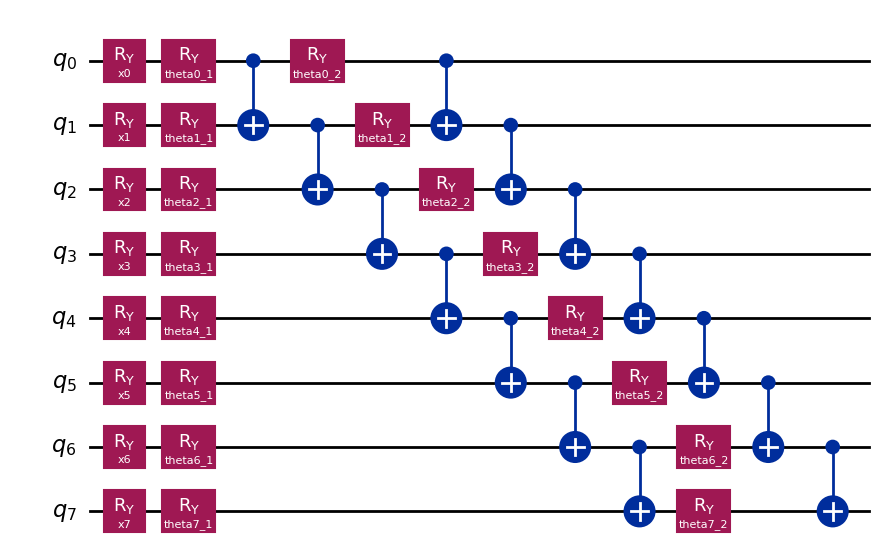

In [9]:
qc.draw(output='mpl')

## 🏗️ Quantum Neural Network (QNN) Construction

In this step, we transform the parameterized quantum circuit (PQC) into a **trainable quantum neural network** that can interface with PyTorch.

### 🔹 Key Components
- **Backend Simulator:**  
  We use `AerSimulator` with the **statevector method** to simulate the quantum circuit on a classical machine.
- **Estimator:**  
  `EstimatorV2` evaluates expectation values of the specified observables for given input and trainable parameters.
- **Gradient Computation:**  
  The **parameter-shift rule** is used to compute gradients for all trainable parameters:
  - For each parameter θ, evaluate the circuit twice: θ + π/2 and θ − π/2.
  - The difference gives the gradient w.r.t. that parameter.
- **EstimatorQNN:**  
  Combines the circuit, estimator, input parameters, weight parameters, and observables into a QNN object.
- **TorchConnector:**  
  Bridges the QNN with PyTorch, allowing seamless integration of the quantum layer into a hybrid classical-quantum model.

### ⚡ Output
- `qnn`: The QNN object for quantum computations and gradient evaluation.
- `qnn_torch`: A PyTorch-compatible module that can be used as a layer in the hybrid neural network.


In [10]:
def build_qnn(qc, x_params, theta_params, observables):
    backend = AerSimulator(method='statevector')  # Quantum simulator backend
    estimator = EstimatorV2(mode=backend)         # Evaluates circuit expectation values

    # Gradient computation using the parameter-shift rule
    # For each trainable parameter, the circuit is evaluated twice:
    # once with the parameter shifted +pi/2, once with -pi/2, then the difference gives the gradient
    gradient = ParamShiftEstimatorGradient(estimator)

    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        input_params=x_params,
        weight_params=theta_params,
        observables=observables,
        gradient=gradient,
        input_gradients=True
    )

    qnn_torch = TorchConnector(qnn)  # Link the QNN with PyTorch for hybrid training
    return qnn, qnn_torch

qnn, qnn_torch = build_qnn(qc, x_params, theta_params, observables)

## 🧬 Hybrid Quantum-Classical Model

In this section, we define the **Hybrid Neural Network** architecture. This model pipelines the quantum feature extractor into classical dense layers to perform the final binary classification.

### 🔹 Model Architecture
1.  **Quantum Layer (`qlayer`)**
    * **Input:** Accepts the batch of 8 normalized clinical features.
    * **Output:** Returns a **single expectation value** (scalar) per sample, representing the collapsed quantum state.
    * *Role:* Acts as a trainable, non-linear feature extractor.

2.  **Classical Hidden Layer (`hidden`)**
    * **Transformation:** Expands the single quantum output into **8 hidden neurons** (`nn.Linear(1, 8)`).
    * **Activation:** Applies **ReLU** to introduce classical non-linearity and filter negative signals.

3.  **Output Layer (`fc`)**
    * **Transformation:** Compresses the 8 hidden features down to **1 output logit** (`nn.Linear(8, 1)`).
    * *Role:* Produces the final raw score used to predict the presence of heart disease (Binary Classification).

### ⚡ Training Setup
* **Loss Function:** `BCEWithLogitsLoss` (Binary Cross-Entropy). This is numerically stable as it combines a Sigmoid layer and the BCELoss in one class.
* **Optimizer:** **Adam** optimizer is used for adaptive learning rates.
* **Weight Initialization:** Classical weights are initialized from a uniform distribution $[-0.1, 0.1]$ to ensure stable starting gradients.

In [11]:
class HybridModel(nn.Module):
    def __init__(self, qlayer):
        super().__init__()
        self.qlayer = qlayer
        
        # Classical layers:
        # 1. Expand the single quantum output to 8 classical neurons
        self.hidden = nn.Linear(1, 8) 
        
        # 2. Output layer: 8 neurons -> 1 binary logit
        self.relu = nn.ReLU()
        self.fc = nn.Linear(8, 1)

        # Initialize weights for stability
        torch.nn.init.uniform_(self.hidden.weight, -0.1, 0.1)
        torch.nn.init.uniform_(self.fc.weight, -0.1, 0.1)

    def forward(self, x):
        # 1. Quantum Pass
        # x shape: (batch, 8) -> qlayer(x) shape: (batch, 1)
        x = self.qlayer(x) 
        
        # Ensure x is explicitly 2D: (batch, 1) before the classical layers
        if x.dim() == 1:
            x = x.unsqueeze(1) 
            
        # 2. Classical Pass
        x = self.hidden(x)
        x = self.relu(x)
        x = self.fc(x)
        return x

# Instantiate the model
model = HybridModel(qlayer=qnn_torch)

# Training Configuration
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 🏋️ Training the Hybrid Model

We train the hybrid quantum-classical model using mini-batch gradient descent. The optimization updates both the **quantum parameters** ($\theta$) and the **classical weights** simultaneously.

### 🔹 Training Procedure
1. **Epoch Loop**: We iterate through the dataset for a defined number of `EPOCHS`.
2. **Batch Processing**:
   - We use `tqdm` to display a real-time progress bar for each batch.
   - **Forward Pass**: The inputs flow through the quantum circuit (feature extraction) and classical layers (classification).
   - **Loss Computation**: We calculate the error using the criterion (BCEWithLogitsLoss).
   - **Backpropagation**: Gradients are propagated back through the classical layers and then through the quantum circuit (via the parameter-shift rule).
   - **Optimization**: The `Adam` optimizer updates all trainable parameters.
3. **Metric Tracking**:
   - **Predictions**: Raw logits are converted to probabilities via **Sigmoid** and thresholded at **0.5** to determine the class (0 or 1).
   - **Accuracy**: We track the percentage of correct predictions per epoch.
   - **Loss**: We calculate the average loss over the entire dataset.
4. **Logging**: Summary statistics are printed every `LOG_INTERVAL` epochs to monitor convergence.

In [11]:
# Lists to store metrics for visualization
train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    # Create a progress bar for the current epoch
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for batch_x, batch_y in loop:
        batch_x = batch_x.float()

        # 1. Zero Gradients
        optimizer.zero_grad()

        # 2. Forward Pass
        outputs = model(batch_x)
        
        # 3. Calculate Loss
        loss = criterion(outputs, batch_y)
        
        # 4. Backward Pass & Optimize
        loss.backward()
        optimizer.step()

        # 5. Track Metrics
        epoch_loss += loss.item() * batch_x.size(0)

        # Convert logits -> probabilities -> binary class (0 or 1)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        correct += (preds == batch_y).sum().item()
        total += batch_x.size(0)

        # Update progress bar
        loop.set_postfix(loss=epoch_loss / total, acc=correct / total)

    # Calculate average loss and accuracy for the epoch
    epoch_loss /= total
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Log progress
    if LOG_INTERVAL is not None and (epoch + 1) % LOG_INTERVAL == 0:
        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Train Accuracy={epoch_acc:.4f}")

Epoch 1: Loss=0.6946, Train Accuracy=0.4917


Epoch 2: Loss=0.6868, Train Accuracy=0.5579


Epoch 3: Loss=0.6769, Train Accuracy=0.5579


Epoch 4: Loss=0.6565, Train Accuracy=0.5579


Epoch 5: Loss=0.6129, Train Accuracy=0.5579


Epoch 6: Loss=0.5850, Train Accuracy=0.7273


Epoch 7: Loss=0.5700, Train Accuracy=0.7521


Epoch 8: Loss=0.5567, Train Accuracy=0.7521


Epoch 9: Loss=0.5477, Train Accuracy=0.7521


Epoch 10: Loss=0.5378, Train Accuracy=0.7521


Epoch 11: Loss=0.5346, Train Accuracy=0.7521


Epoch 12: Loss=0.5267, Train Accuracy=0.7397


Epoch 13: Loss=0.5219, Train Accuracy=0.7521


Epoch 14: Loss=0.5214, Train Accuracy=0.7521


Epoch 15: Loss=0.5181, Train Accuracy=0.7521


Epoch 16: Loss=0.5172, Train Accuracy=0.7521


Epoch 17: Loss=0.5115, Train Accuracy=0.7521


Epoch 18: Loss=0.5121, Train Accuracy=0.7355


Epoch 19: Loss=0.5085, Train Accuracy=0.7521


Epoch 20: Loss=0.5110, Train Accuracy=0.7479


### 💾 Saving Trained Model and Metrics

After training, we save the **hybrid model parameters** and **training metrics** for future evaluation or reuse, based on the chosen encoding.

### ⚡ Saving Procedure
1. **Model Weights:** saved with `torch.save(model.state_dict(), model_path)`.  
2. **Training Metrics:** loss and accuracy per epoch saved with `np.save(metrics_path, [train_losses, train_accuracies])`.

This ensures **experiment reproducibility** and allows later comparison between plain and richer encodings.

In [12]:
if USE_RICHER_ENCODING:
    model_path = RICH_ENCODING_MODEL_PATH
    metrics_path = RICH_ENCODING_METRICS_PATH
else:
    model_path = PLAIN_ENCODING_MODEL_PATH
    metrics_path = PLAIN_ENCODING_METRICS_PATH

torch.save(model.state_dict(), model_path)
np.save(metrics_path, [train_losses, train_accuracies])

## 🧪 Model Evaluation & Visualization

In this section, we first **set up the evaluation environment** by loading the trained hybrid quantum-classical models (plain and richer encoding) and retrieving the previously saved **training metrics** (losses and accuracies).  

With the models and metrics ready, we perform a comprehensive evaluation and visualization.

### ⚡ What We Do Here
- **Setup & Retrieval:**  
  - Load both hybrid models using `load_hybrid_model`.  
  - Organize them in a dictionary for easy iteration.  
  - Load saved training metrics (losses and accuracies) for plotting and comparison.

- **Training Performance:**  
  - Plot **loss and accuracy curves** for plain vs richer encoding.

- **Test Set Evaluation:**  
  - Compute test accuracy, **confusion matrices**, and **classification reports**.

- **Model Internals Visualization:**  
  - Inspect **quantum layer outputs**.  
  - Compute and visualize **feature saliency maps**.  
  - Analyze **latent embeddings** via PCA.

- **Parameter Sensitivity:**  
  - Examine gradients of trainable parameters to assess their influence on predictions.
 
* **Explainability & Interpretability Metrics:**

  * **Feature Saliency / Average Feature Sensitivity** → highlights which input features most influence model outputs.
  * **Sparseness (L1/L2 ratio)** → quantifies how concentrated or diffuse the saliency map is.
  * **Saliency Entropy** → measures how spread out the saliency values are across features.
  * **Deletion Metric / Fidelity** → tests if removing top-salient features reduces true-class probability.
  * **Bug / Overreliance Detection** → compares saliency for correct vs incorrect predictions to detect misalignment or potential model bias.
  * **Minimum Efficacy** → evaluates if saliency provides information beyond raw model confidence.
  * **Overreliance Risk** → correlation between confidence and fidelity to check if explanations could mislead humans by overstating certainty.

- **Statistical Testing:**  
  - Use the **Wilcoxon signed-rank test** to quantify differences in feature importance between plain and richer encoding.
 
### ⚠️ Note on Classical vs Quantum Metrics

Most of the metrics above are **classical interpretability metrics**, widely established in XAI literature.

* This is because **quantum-specific explainability metrics are still scarce**, and the field lacks standardized methods for analyzing hybrid quantum-classical models.
* Using classical metrics allows us to **evaluate and compare the hybrid models in a rigorous and interpretable way**, even though part of the model is quantum.

In [12]:
def load_hybrid_model(richer_encoding: bool, saved_model_path: str):
    global USE_RICHER_ENCODING
    original_flag = USE_RICHER_ENCODING
    USE_RICHER_ENCODING = richer_encoding

    # Build quantum circuit
    qc, x_params, theta_params, observables = build_quantum_circuit(use_richer_encoding=USE_RICHER_ENCODING)

    # Build QNN and Torch connector
    _, qnn_torch = build_qnn(qc, x_params, theta_params, observables)

    # Create model and attach the quantum layer
    model = HybridModel(qnn_torch)

    # Load saved weights
    model.load_state_dict(torch.load(saved_model_path))
    model.eval()

    # Restore the original flag
    USE_RICHER_ENCODING = original_flag
    return model

# Load trained hybrid models for both encoding types
model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)

# Organize models in a dictionary for convenience
models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

# Load previously saved training metrics (losses and accuracies)
plain_losses, plain_acc = np.load(PLAIN_ENCODING_METRICS_PATH + ".npy", allow_pickle=True)
rich_losses, rich_acc   = np.load(RICH_ENCODING_METRICS_PATH + ".npy", allow_pickle=True)

### 📈 Training Loss and Accuracy Comparison

This plot shows the **training performance** of the hybrid models for both **plain** and **richer encoding** schemes.

- **Left Plot — Training Loss:**  
  Visualizes how the cross-entropy loss decreases over epochs for each model. Lower values indicate better learning.

- **Right Plot — Training Accuracy:**  
  Shows the proportion of correctly classified training samples per epoch. Higher values indicate better model performance.

By comparing these curves, we can see the **impact of richer encoding** on learning speed and stability.

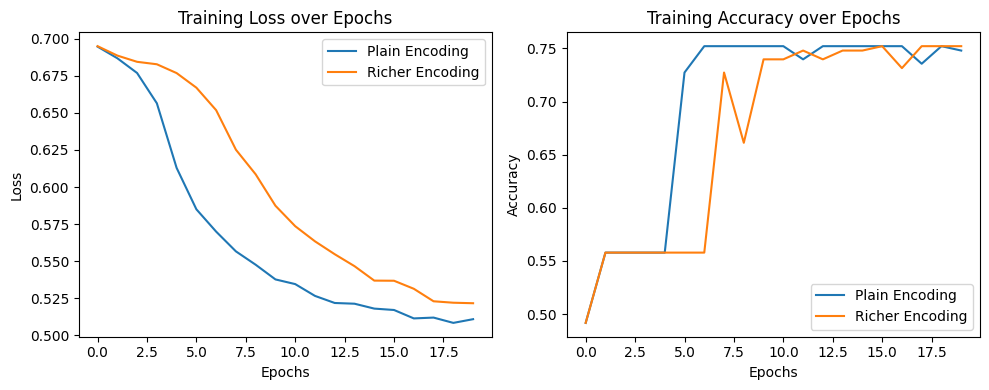

In [13]:
plt.figure(figsize=(10,4))

# Training Loss
plt.subplot(1,2,1)
plt.plot(plain_losses, label="Plain Encoding")
plt.plot(rich_losses, label="Richer Encoding")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

# Training Accuracy
plt.subplot(1,2,2)
plt.plot(plain_acc, label="Plain Encoding")
plt.plot(rich_acc, label="Richer Encoding")
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

plt.tight_layout()
plt.show()

### 📊 Classification Reports

This section provides **detailed evaluation metrics** for each model on the test set:

- **Precision:** The proportion of positive predictions that were actually correct (e.g., how many predicted "Positive/High Risk" cases were real).
- **Recall:** The ability to find all positive instances (e.g., how many actual "Positive/High Risk" cases the model successfully detected).
- **F1-score:** The harmonic mean of precision and recall; a balanced metric useful for uneven class distributions.
- **Support:** The number of actual samples for each class in the test set.

Comparing the reports for **Plain vs. Richer Encoding** helps us determine if the added circuit complexity improves the model's sensitivity (Recall) or reduces false alarms (Precision) when distinguishing between the two clinical classes.

In [15]:
for name, mdl in models.items():
    with torch.no_grad():
        outputs = mdl(X_test)                     # Forward pass
        preds = (torch.sigmoid(outputs) >= 0.5).int()  # Threshold at 0.5 for binary

    # Convert tensors to NumPy for sklearn
    y_true = y_test.numpy()
    y_pred = preds.numpy()

    # Print detailed classification metrics
    print(f"\n{name} Classification Report:")
    print(classification_report(
        y_true,
        y_pred,
        target_names=["No", "Yes"]  # Binary class labels
    ))


Plain Encoding Classification Report:
              precision    recall  f1-score   support

          No       0.75      0.93      0.83        29
         Yes       0.92      0.72      0.81        32

    accuracy                           0.82        61
   macro avg       0.83      0.82      0.82        61
weighted avg       0.84      0.82      0.82        61


Richer Encoding Classification Report:
              precision    recall  f1-score   support

          No       0.77      0.93      0.84        29
         Yes       0.92      0.75      0.83        32

    accuracy                           0.84        61
   macro avg       0.85      0.84      0.84        61
weighted avg       0.85      0.84      0.84        61



### 🧩 Test Accuracy and Confusion Matrices

In this section, we **evaluate the trained hybrid models** on the test set and visualize their performance.

- **Test Accuracy:**  
  Prints the overall accuracy for each model (plain vs richer encoding).

- **Confusion Matrices:**  
  Show how well each model predicts each Iris species.  
  - Diagonal values: correctly classified samples  
  - Off-diagonal values: misclassifications  

This visualization allows quick comparison of **classification strengths and weaknesses** between the two encoding approaches.

Plain Encoding - Test Accuracy: 0.8197
Richer Encoding - Test Accuracy: 0.8361


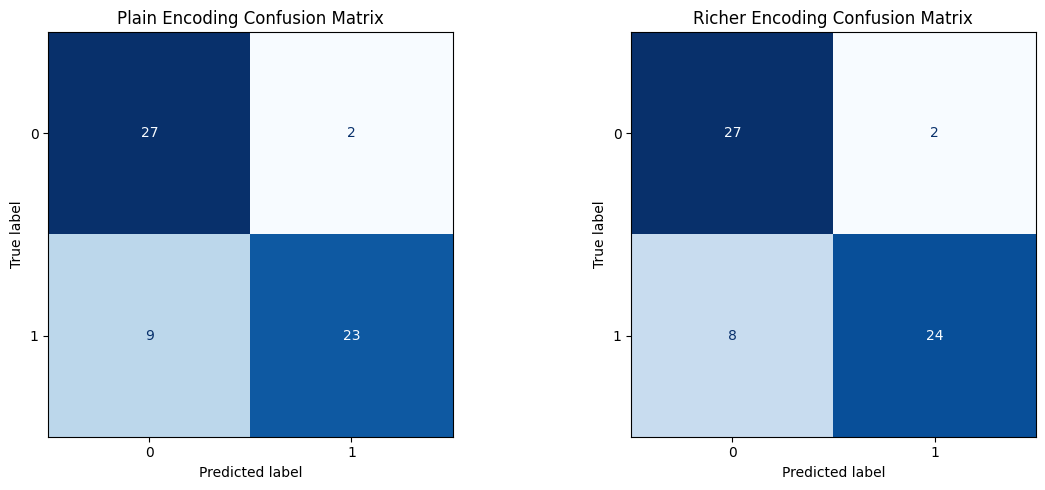

In [16]:
plt.figure(figsize=(12, 5))

for i, (name, mdl) in enumerate(models.items()):
    with torch.no_grad():  # Disable gradients for evaluation
        outputs = mdl(X_test)  # Forward pass

        # For BCEWithLogitsLoss (single output), threshold at 0.5
        preds = (torch.sigmoid(outputs) >= 0.5).int()  

        # Compute test accuracy
        test_acc = (preds == y_test.int()).float().mean().item()
        print(f"{name} - Test Accuracy: {test_acc:.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_test.numpy(), preds.numpy())
        plt.subplot(1, len(models), i+1)  # Correct subplot positioning
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
        plt.title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

### 🔬 Comparative Stability Analysis: Accuracy & Saliency across Seeds

In this section, we assess the **robustness** and **reproducibility** of our hybrid models. Since quantum neural networks can be sensitive to weight initialization and data shuffling, it is critical to verify if the model's performance and explanations are consistent across different runs.

We perform this analysis for **both** encoding strategies (**Plain** vs. **Richer**) to determine if increasing the quantum circuit complexity affects stability.

#### 🎯 Objectives
1.  **Performance Consistency:** Does the model reliably reach high accuracy, or does it vary significantly based on random initialization? Is one encoding more volatile than the other?
2.  **Explanation Stability:** Check if the model consistently identifies the same features as "important" (Saliency). We use **Spearman’s Rank Correlation** ($\rho$) to compare the ranking of feature importance between the first seed and subsequent seeds.
    * $\rho \approx 1.0$: Highly stable explanations (same features are always important).
    * $\rho \approx 0.0$: Unstable/Random explanations.

> **Note:** We rebuild the entire Quantum Neural Network and PyTorch model from scratch for each seed to ensure complete independence between runs. We also limit the training to **3 epochs** here to perform a rapid assessment without excessive runtime.


Running Stability Analysis for: Plain Encoding
   (Seeds=5, Epochs=3)
   Done!                                      
   Results for Plain Encoding
   • Test Accuracy: 59.3% ± 14.5%
   • Saliency Stability (Avg ρ): 0.554


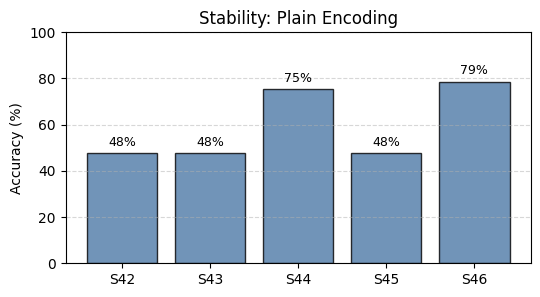

--------------------------------------------------

Running Stability Analysis for: Richer Encoding
   (Seeds=5, Epochs=3)
   Done!                                      
   Results for Richer Encoding
   • Test Accuracy: 47.5% ± 0.0%
   • Saliency Stability (Avg ρ): 0.613


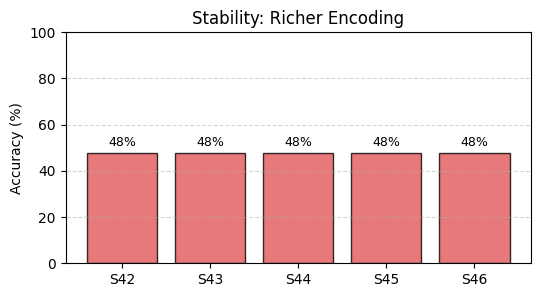

--------------------------------------------------


In [14]:
# Prevent thread contention
torch.set_num_threads(1)

def get_global_saliency(model, X_data):
    """Computes Global Saliency (Input Gradients)"""
    model.eval()
    inputs = X_data.clone().detach().requires_grad_(True)
    outputs = model(inputs)
    outputs.sum().backward()
    saliency = inputs.grad.abs().mean(dim=0).cpu().detach().numpy()
    return saliency

def run_training_seed(seed, use_richer, epochs=3): 
    """
    Trains a fresh model from scratch with a specific encoding and seed.
    """
    # 1. Set Seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # 2. Re-build Quantum Circuit & QNN (Fresh Start)
    # Explicitly pass the 'use_richer' flag here so we build the correct circuit
    qc_temp, x_temp, theta_temp, obs_temp = build_quantum_circuit(use_richer_encoding=use_richer)
    _, qnn_torch_temp = build_qnn(qc_temp, x_temp, theta_temp, obs_temp)
    
    local_model = HybridModel(qlayer=qnn_torch_temp) 
    local_optimizer = torch.optim.Adam(local_model.parameters(), lr=LEARNING_RATE)
    local_criterion = nn.BCEWithLogitsLoss()
    
    # 3. Training Loop
    local_model.train()
    for ep in range(epochs):
        # Only print every epoch to reduce clutter
        # print(f"   Seed {seed}: Epoch {ep+1}/{epochs}...", end="\r")
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.float()
            local_optimizer.zero_grad()
            out = local_model(batch_x)
            loss = local_criterion(out, batch_y)
            loss.backward()
            local_optimizer.step()
            
    # 4. Evaluation
    local_model.eval()
    with torch.no_grad():
        preds = local_model(X_test)
        predicted_labels = (torch.sigmoid(preds) > 0.5).float()
        acc = (predicted_labels == y_test).sum().item() / len(y_test)
        
    saliency_map = get_global_saliency(local_model, X_test)
    return acc, saliency_map

# ===== Run the Suite for Both Encodings =====
STABILITY_SEEDS = [42, 43, 44, 45, 46]
STABILITY_EPOCHS = 3 

# Configurations to test
configs = [
    ("Plain Encoding", False),
    ("Richer Encoding", True)
]

for label, use_richer in configs:
    print(f"\nRunning Stability Analysis for: {label}")
    print(f"   (Seeds={len(STABILITY_SEEDS)}, Epochs={STABILITY_EPOCHS})")
    
    accs_list = []
    globs_list = []

    for s in STABILITY_SEEDS:
        print(f"   > Training Seed {s}...", end="\r")
        acc, glob = run_training_seed(s, use_richer, epochs=STABILITY_EPOCHS)
        accs_list.append(acc)
        globs_list.append(glob)
    
    print(f"   Done!                                      ")

    accs_np = np.array(accs_list)
    globs_np = np.stack(globs_list)

    # Spearman Correlation vs First Seed
    rhos = [spearmanr(globs_np[0], globs_np[i]).correlation for i in range(1, len(STABILITY_SEEDS))]

    # ===== Visualization per Config =====
    print(f"   Results for {label}")
    print(f"   • Test Accuracy: {accs_np.mean()*100:.1f}% ± {accs_np.std()*100:.1f}%")
    if len(rhos) > 0:
        print(f"   • Saliency Stability (Avg ρ): {np.mean(rhos):.3f}")
    
    # Plot
    plt.figure(figsize=(6, 3))
    color = '#4e79a7' if not use_richer else '#e15759'
    bars = plt.bar([f"S{s}" for s in STABILITY_SEEDS], accs_np * 100, color=color, edgecolor='black', alpha=0.8)
    plt.ylabel("Accuracy (%)")
    plt.title(f"Stability: {label}")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 2,
                 f'{height:.0f}%', ha='center', va='bottom', fontsize=9)
    plt.show()
    print("-" * 50)

### 🔍 Feature Saliency Analysis

This section analyzes **how sensitive the model outputs are to each input feature**:

- **Saliency Maps:**  
  - Computed using a finite difference method: perturb each feature slightly and observe the change in output.  
  - Rows = test samples, columns = features.  
  - Color intensity indicates how strongly the model output responds to that feature.

- **Average Feature Saliency:**  
  - Aggregates the saliency values across all samples for each feature.  
  - Bar plots allow direct comparison of **plain vs richer encoding** models.  

Insights:  
- Features with higher saliency are more important for the model’s decision.  
- Differences between plain and richer encoding indicate how the extra RZ rotations influence feature representation.

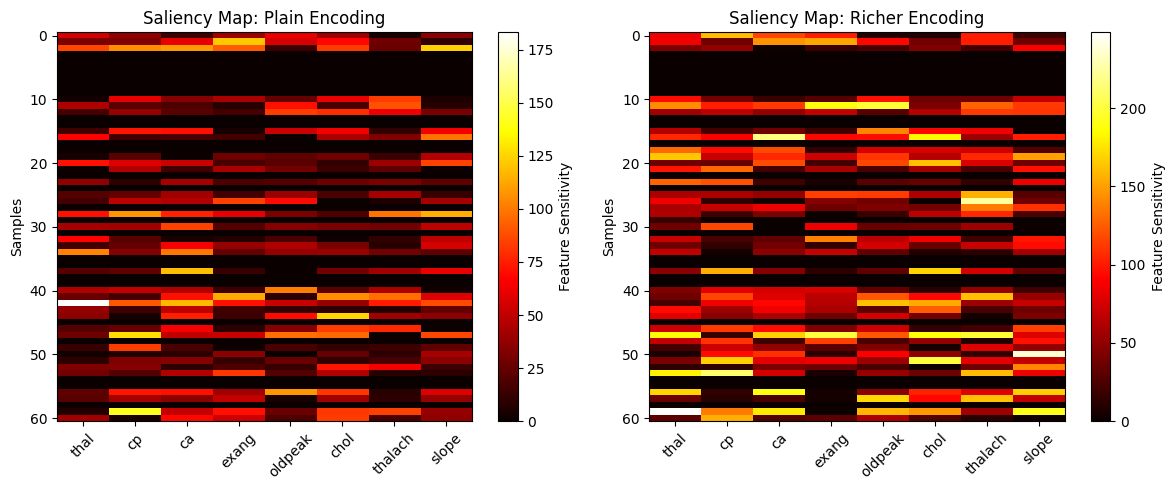

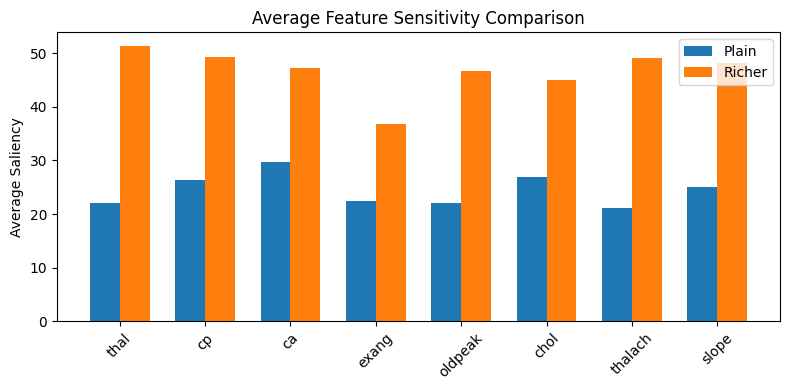

In [15]:
def compute_saliency(model, inputs, delta=1e-3):
    model.eval()
    inputs = inputs.clone().detach()
    base_output = model(inputs).detach().numpy()
    saliency = np.zeros_like(inputs)

    for feature_idx in range(inputs.shape[1]):
        perturbed = inputs.clone()
        perturbed[:, feature_idx] += delta
        perturbed_output = model(perturbed).detach().numpy()
        grad_estimate = (perturbed_output - base_output) / delta
        if grad_estimate.ndim > 1:
            saliency[:, feature_idx] = np.mean(np.abs(grad_estimate), axis=1)
        else:
            saliency[:, feature_idx] = np.abs(grad_estimate)
    
    return saliency

saliency_plain = compute_saliency(model_plain, X_test)
saliency_rich  = compute_saliency(model_rich, X_test)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(saliency_plain, cmap='hot', aspect='auto')
plt.colorbar(label="Feature Sensitivity")
plt.title("Saliency Map: Plain Encoding")
plt.xticks(range(X_test.shape[1]), TOP_8_FEATS, rotation=45)
plt.ylabel("Samples")

plt.subplot(1,2,2)
plt.imshow(saliency_rich, cmap='hot', aspect='auto')
plt.colorbar(label="Feature Sensitivity")
plt.title("Saliency Map: Richer Encoding")
plt.xticks(range(X_test.shape[1]), TOP_8_FEATS, rotation=45)
plt.ylabel("Samples")

plt.tight_layout()
plt.show()

mean_plain = saliency_plain.mean(axis=0)
mean_rich  = saliency_rich.mean(axis=0)

plt.figure(figsize=(8,4))
x = np.arange(len(TOP_8_FEATS))
width = 0.35
plt.bar(x - width/2, mean_plain, width, label="Plain")
plt.bar(x + width/2, mean_rich, width, label="Richer")
plt.xticks(x, TOP_8_FEATS, rotation=45)
plt.ylabel("Average Saliency")
plt.title("Average Feature Sensitivity Comparison")
plt.legend()
plt.tight_layout()
plt.show()

### 🧪 Average Sensitivity (Stability of Explanations)

This section evaluates **how stable the model’s saliency explanations are** under small perturbations of the input.

* **Purpose:**
  Average Sensitivity measures whether tiny random changes to the input cause large changes in the saliency values.
  A good explanation method should be **stable** e.g. small input noise should not radically alter which features appear important.

* **Method:**

  1. Compute the original saliency map for the model.
  2. Add a very small random perturbation (Gaussian noise scaled by `δ`) to each input sample.
  3. Recompute the saliency on the perturbed input.
  4. Measure the **mean absolute difference** between the two saliency maps.

* **Interpretation:**

  * **Low Average Sensitivity** -> robust, stable explanations.
  * **High Average Sensitivity** -> explanations are fragile and inconsistent.
  * Comparing values for **plain** vs **richer encoding** reveals whether the richer architecture produces more reliable feature attributions.

This metric helps ensure that saliency-based explanations are not just accurate but also **consistent**, which is critical for human trust and interpretability.

In [16]:
def average_sensitivity(model, inputs, delta=1e-3, saliency_fn=compute_saliency):
    # Original saliency
    saliency_orig = saliency_fn(model, inputs, delta)
    
    # Add small random noise to inputs
    noise = torch.randn_like(inputs) * delta
    inputs_perturbed = inputs + noise
    
    # Saliency for perturbed inputs
    saliency_perturbed = saliency_fn(model, inputs_perturbed, delta)
    
    # Compute average absolute difference
    avg_sens = np.mean(np.abs(saliency_orig - saliency_perturbed))
    return avg_sens

avg_sens_plain = average_sensitivity(model_plain, X_test)
avg_sens_rich  = average_sensitivity(model_rich, X_test)

print("Average Sensitivity (Plain):", avg_sens_plain)
print("Average Sensitivity (Richer):", avg_sens_rich)

Average Sensitivity (Plain): 21.214615
Average Sensitivity (Richer): 44.392387


### 📊 Feature Importance Stability: Plain vs. Richer Encoding

After running the stability suite, we visualize the **average saliency** of each clinical feature across all random seeds for **both model architectures**.

We generate two separate plots to compare:
1.  **Plain Encoding:** Does the basic quantum embedding consistently rely on the same features?
2.  **Richer Encoding:** Does adding $RZ$ rotation gates change the feature focus or the stability of the explanations?

**How to Interpret the Plots:**
* **Height of the Bar:** Represents the **mean global saliency** (how much the model focuses on this feature on average).
* **Error Bar (Black Line):** Represents the **standard deviation** across seeds.
    * *Small error bars* $\rightarrow$ The model consistently rates this feature as important/unimportant (High Stability).
    * *Large error bars* $\rightarrow$ The importance of this feature varies significantly depending on weight initialization (Low Stability).

This comparison helps us determine if the "top features" are genuine biological signals or artifacts of a specific random seed, and whether one encoding scheme is more robust than the other.


Processing: Plain Encoding...


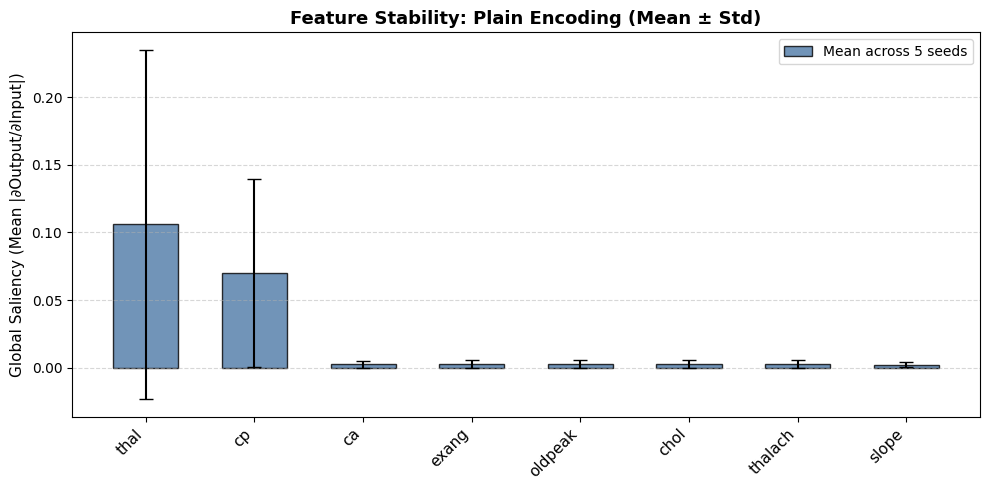

   Plot generated for Plain Encoding

Processing: Richer Encoding...


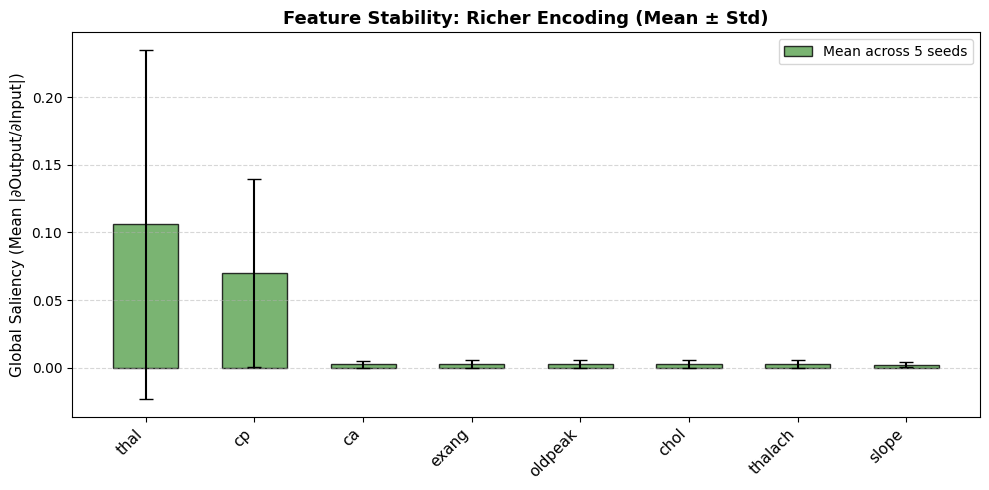

   Plot generated for Richer Encoding


In [17]:
def plot_feature_stability(globs_np, title, color_code):
    """
    Plots the mean saliency with error bars across seeds.
    """
    # 1. Compute Statistics
    mean_saliency = globs_np.mean(axis=0)
    std_saliency  = globs_np.std(axis=0)

    # 2. Setup Plot
    x_indices = np.arange(len(feature_cols))
    width = 0.6
    
    plt.figure(figsize=(10, 5))

    # 3. Create Bar Chart with Error Bars
    plt.bar(x_indices, mean_saliency, 
            yerr=std_saliency, 
            capsize=5, 
            width=width, 
            color=color_code, 
            edgecolor='black', 
            alpha=0.8,
            label=f"Mean across {len(STABILITY_SEEDS)} seeds")

    # 4. Formatting
    plt.xticks(x_indices, feature_cols, rotation=45, ha='right', fontsize=11)
    plt.ylabel("Global Saliency (Mean |∂Output/∂Input|)", fontsize=11)
    plt.title(f"{title} (Mean ± Std)", fontsize=13, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# Run Comparison Loop
# ---------------------------------------------------------
configs = [
    ("Plain Encoding", False, '#4e79a7'),  # Blue-ish
    ("Richer Encoding", True,  '#59a14f')   # Green-ish
]

for label, use_richer, color in configs:
    print(f"\nProcessing: {label}...")
    
    # Plot Immediately
    plot_feature_stability(globs_np, title=f"Feature Stability: {label}", color_code=color)
    print(f"   Plot generated for {label}")

### 🧩 Comparative Saliency Rank Stability (Heatmaps)

While the previous bar charts showed the *average* importance, these heatmaps reveal the **consistency of rankings** between individual training runs for both encoding strategies.

We compute the **Spearman Rank Correlation** ($\rho$) between every pair of seeds:
* **Cell (i, j)** represents how similarly "Seed $i$" and "Seed $j$" ranked the features.
* **$\rho \approx 1.0$ (Yellow):** Both seeds identified the exact same order of important features.
* **$\rho < 0.5$ (Dark/Purple):** The feature rankings are significantly different, indicating the explanation is fragile and depends on initialization.

**Goal:** We want to see which encoding method produces a **brighter, more uniform heatmap**, indicating higher trustworthiness.


🔄 Generating Heatmap for: Plain Encoding...


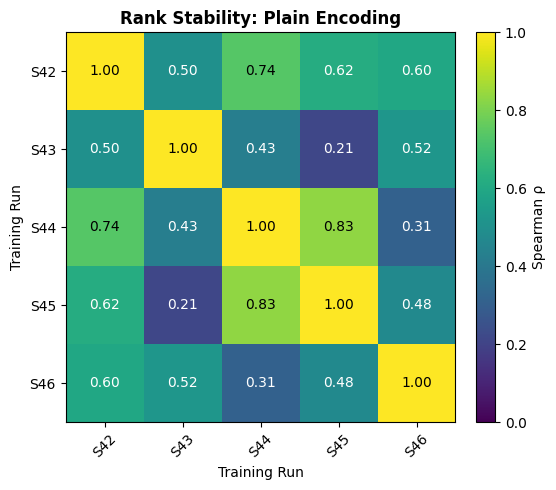


🔄 Generating Heatmap for: Richer Encoding...


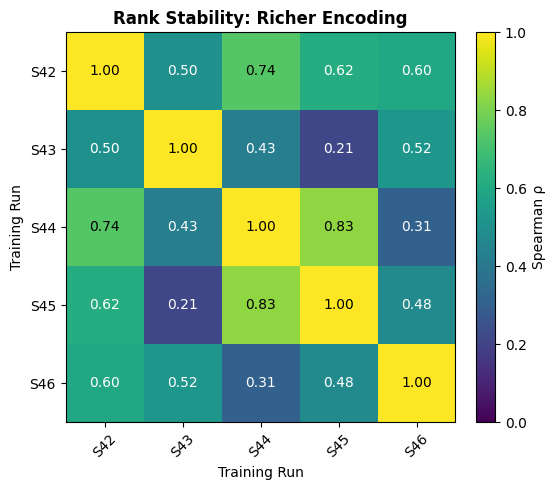

In [18]:
def pairwise_spearman(globs):
    """
    Computes a pairwise Spearman correlation matrix.
    Input: (num_seeds, num_features) -> Output: (num_seeds, num_seeds)
    """
    n = globs.shape[0]
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            ra = np.argsort(np.argsort(globs[i]))
            rb = np.argsort(np.argsort(globs[j]))
            M[i,j] = np.corrcoef(ra, rb)[0,1]
    return M

def show_heatmap(M, title, seed_labels):
    plt.figure(figsize=(6, 5))
    im = plt.imshow(M, vmin=0, vmax=1, cmap='viridis')
    plt.colorbar(im, fraction=0.046, pad=0.04, label="Spearman ρ")
    
    # Ticks and Labels
    indices = range(M.shape[0])
    plt.xticks(indices, seed_labels, rotation=45)
    plt.yticks(indices, seed_labels)
    
    # Annotate values
    for i in range(M.shape[0]):
        for j in range(M.shape[0]):
            text = plt.text(j, i, f"{M[i, j]:.2f}",
                           ha="center", va="center", color="w" if M[i, j] < 0.7 else "k")

    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel("Training Run")
    plt.ylabel("Training Run")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# Run Comparison for Heatmaps
# ---------------------------------------------------------

configs = [("Plain Encoding", False), ("Richer Encoding", True)]
seed_labels = [f"S{s}" for s in STABILITY_SEEDS]

for label, use_richer in configs:
    print(f"\n🔄 Generating Heatmap for: {label}...")

    # Compute Matrix
    M_stability = pairwise_spearman(globs_np)

    # Visualize
    show_heatmap(M_stability, f"Rank Stability: {label}", seed_labels)

### ⚡ Comparative Local Attribution: Gradient × Input

In this section, we compare the **Gradient × Input** attribution for both the **Plain** and **Richer** encoding models.

The metric is defined as:
$$\text{Attribution}_i = |x_i \odot \nabla_{x_i} F(x)|$$

This combines two signals:
1.  **Sensitivity ($\nabla_x$):** How much the model *reacts* to a small change in feature $i$.
2.  **Magnitude ($x$):** The strength of the feature signal in the actual input.

**Goal:**
By visualizing these side-by-side, we can observe if the **Richer Encoding** (with added $RZ$ gates) shifts the model's focus to different clinical features compared to the **Plain Encoding**.

Computing Grad × Input for: Plain Encoding...
Computing Grad × Input for: Richer Encoding...


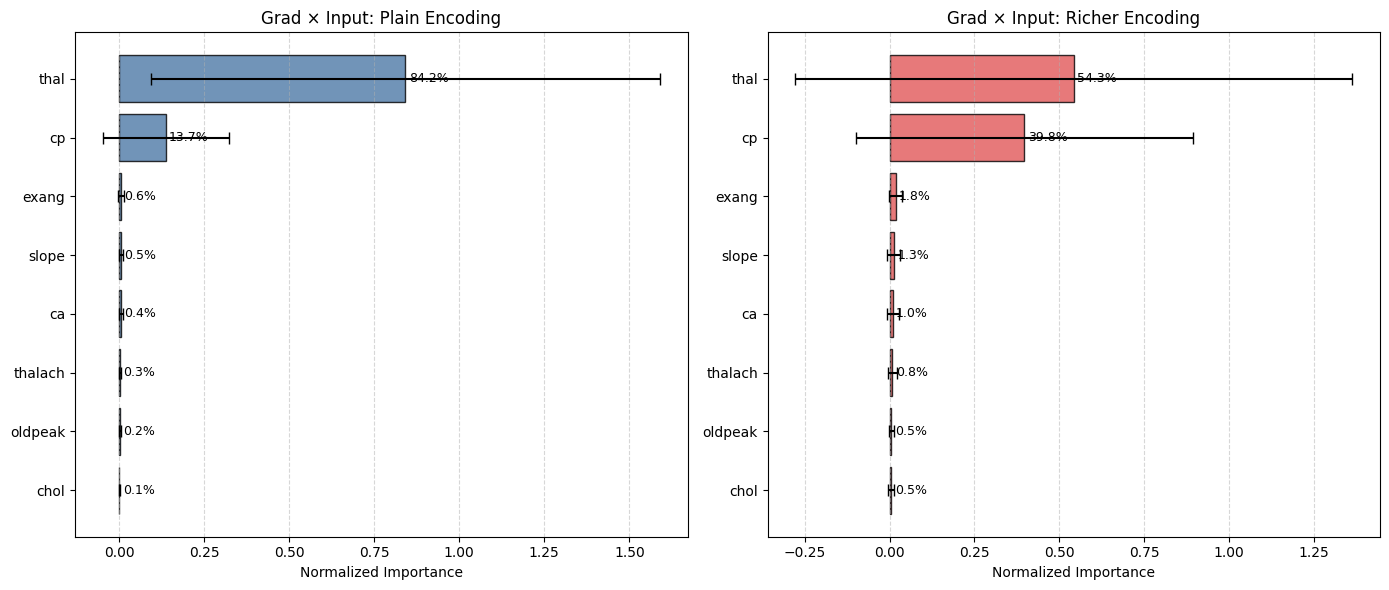

In [19]:
def compute_grad_x_input(model, X_data):
    """
    Computes (Input * Gradient) feature attribution.
    Returns: Global Mean Attribution (normalized) and Standard Deviation (normalized).
    """
    model.eval()
    
    # 1. Enable gradients for input features
    inputs = X_data.clone().detach().requires_grad_(True)
    
    # 2. Forward Pass
    outputs = model(inputs)
    
    # 3. Backward Pass
    outputs.sum().backward()
    
    # 4. Compute Grad * Input (Element-wise)
    grads = inputs.grad.cpu().detach().numpy()
    inputs_np = inputs.cpu().detach().numpy()
    
    # Absolute value to measure magnitude of impact
    raw_attr = np.abs(inputs_np * grads)
    
    # 5. Aggregate globally
    mean_attr = raw_attr.mean(axis=0)
    std_attr  = raw_attr.std(axis=0)
    
    # 6. Normalize to sum to 1
    total = mean_attr.sum()
    return (mean_attr / total), (std_attr / total)

# ---------------------------------------------------------
# 1. Run Analysis on Both Models
# ---------------------------------------------------------
# Load models if not already present
if 'models' not in locals():
    model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
    model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)
    models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

results = {}
for label, model_variant in models.items():
    print(f"Computing Grad × Input for: {label}...")
    results[label] = compute_grad_x_input(model_variant, X_test)

# ---------------------------------------------------------
# 2. Visualization (Side-by-Side)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Plain Encoding': '#4e79a7', 'Richer Encoding': '#e15759'}

for ax, (label, (means, stds)) in zip(axes, results.items()):
    # Sort features by importance for this specific model
    sorted_indices = np.argsort(means)[::-1]
    sorted_features = [feature_cols[i] for i in sorted_indices]
    sorted_means = means[sorted_indices]
    sorted_stds = stds[sorted_indices]

    # Create Bar Plot
    y_pos = np.arange(len(sorted_features))
    ax.barh(y_pos, sorted_means, xerr=sorted_stds, align='center', 
            color=colors[label], edgecolor='black', alpha=0.8, capsize=4)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_features)
    ax.invert_yaxis()  # Highest importance at top
    ax.set_xlabel("Normalized Importance")
    ax.set_title(f"Grad × Input: {label}")
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Add numeric labels
    for i, v in enumerate(sorted_means):
        ax.text(v + 0.01, i, f"{v:.1%}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

### ⚡ Comparative Local Attribution: Integrated Gradients

In this section, we compare **Integrated Gradients (IG)** for both models.
$$IG_i(x) = (x_i - x'_i) \times \int_{\alpha=0}^{1} \frac{\partial F(x' + \alpha \cdot (x - x'))}{\partial x_i} d\alpha$$

Integrated Gradients are generally more robust than "Grad × Input" because they satisfy the **Completeness Axiom** and account for model saturation (e.g., in the flat part of a sigmoid/ReLU).



**Goal:**
We want to see if the richer encoding produces a different "attribution profile" than the plain encoding, indicating that it is leveraging different features to make decisions.

∫ Computing Integrated Gradients for: Plain Encoding (Steps=50)...
∫ Computing Integrated Gradients for: Richer Encoding (Steps=50)...


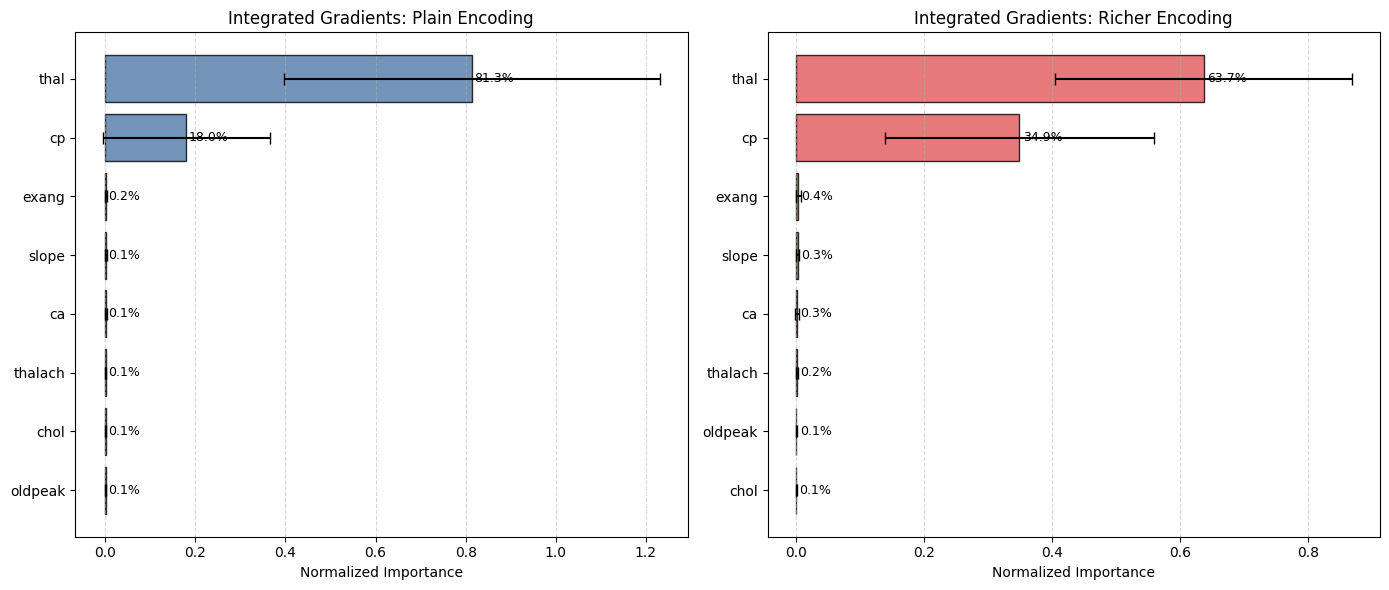

In [20]:
def compute_integrated_gradients(model, X_data, baseline=None, steps=50):
    """
    Computes Integrated Gradients for a batch of inputs using Riemann approximation.
    Returns: Global Mean Attribution (normalized) and Standard Deviation (normalized).
    """
    model.eval()
    
    # 1. Define Baseline (Zero vector)
    if baseline is None:
        baseline = torch.zeros_like(X_data)
        
    grads_accum = torch.zeros_like(X_data)
    alphas = torch.linspace(0, 1, steps)
    
    # 2. Path Integral Loop
    for alpha in alphas:
        # Interpolate: x' + alpha * (x - x')
        x_step = baseline + alpha * (X_data - baseline)
        x_step = x_step.clone().detach().requires_grad_(True)
        
        # Forward Pass
        output = model(x_step)
        
        # Backward Pass
        model.zero_grad()
        output.sum().backward()
        
        # Safety Check for Gradients
        if x_step.grad is None:
            raise ValueError("Gradient is None! Ensure QNN was built with input_gradients=True.")
            
        grads_accum += x_step.grad
        
    # 3. Average Gradients
    avg_grads = grads_accum / steps
    
    # 4. Compute IG: (Input - Baseline) * Average Gradients
    ig_raw = (X_data - baseline) * avg_grads
    ig_raw = ig_raw.detach().cpu().numpy()
    
    # 5. Aggregate globally (Absolute value for magnitude)
    ig_abs = np.abs(ig_raw)
    mean_ig = ig_abs.mean(axis=0)
    std_ig  = ig_abs.std(axis=0)
    
    # 6. Normalize to sum to 1
    total = mean_ig.sum()
    return (mean_ig / total), (std_ig / total)

# ---------------------------------------------------------
# 1. Run Analysis on Both Models
# ---------------------------------------------------------
# Load models if not already present
if 'models' not in locals():
    model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
    model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)
    models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

results_ig = {}
steps_count = 50 # Increase for smoother integrals

for label, model_variant in models.items():
    print(f"∫ Computing Integrated Gradients for: {label} (Steps={steps_count})...")
    results_ig[label] = compute_integrated_gradients(model_variant, X_test, steps=steps_count)

# ---------------------------------------------------------
# 2. Visualization (Side-by-Side)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Plain Encoding': '#4e79a7', 'Richer Encoding': '#e15759'}

for ax, (label, (means, stds)) in zip(axes, results_ig.items()):
    # Sort features by importance for this specific model
    sorted_indices = np.argsort(means)[::-1]
    sorted_features = [feature_cols[i] for i in sorted_indices]
    sorted_means = means[sorted_indices]
    sorted_stds = stds[sorted_indices]

    # Create Bar Plot
    y_pos = np.arange(len(sorted_features))
    ax.barh(y_pos, sorted_means, xerr=sorted_stds, align='center', 
            color=colors[label], edgecolor='black', alpha=0.8, capsize=4)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_features)
    ax.invert_yaxis()  # Highest importance at top
    ax.set_xlabel("Normalized Importance")
    ax.set_title(f"Integrated Gradients: {label}")
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Add numeric labels
    for i, v in enumerate(sorted_means):
        ax.text(v + 0.005, i, f"{v:.1%}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

### ⚡ Comparative Local Attribution: SmoothGrad

In this section, we compare **SmoothGrad** for both models.
$$SG(x) = \frac{1}{K} \sum_{k=1}^{K} \nabla_x F(x + \mathcal{N}(0, \sigma^2))$$

SmoothGrad reduces "noise" in saliency maps by averaging the gradients of slightly perturbed (noisy) versions of the input. It often produces cleaner and more stable explanations than raw gradients, making it a good test of whether the model's feature focus is robust or fragile.

**Goal:**
We want to verify if the richer encoding produces more stable explanations (less variance in feature importance) when subjected to input noise compared to the plain encoding.

🌊 Computing SmoothGrad for: Plain Encoding (K=30, σ=0.1)...
🌊 Computing SmoothGrad for: Richer Encoding (K=30, σ=0.1)...


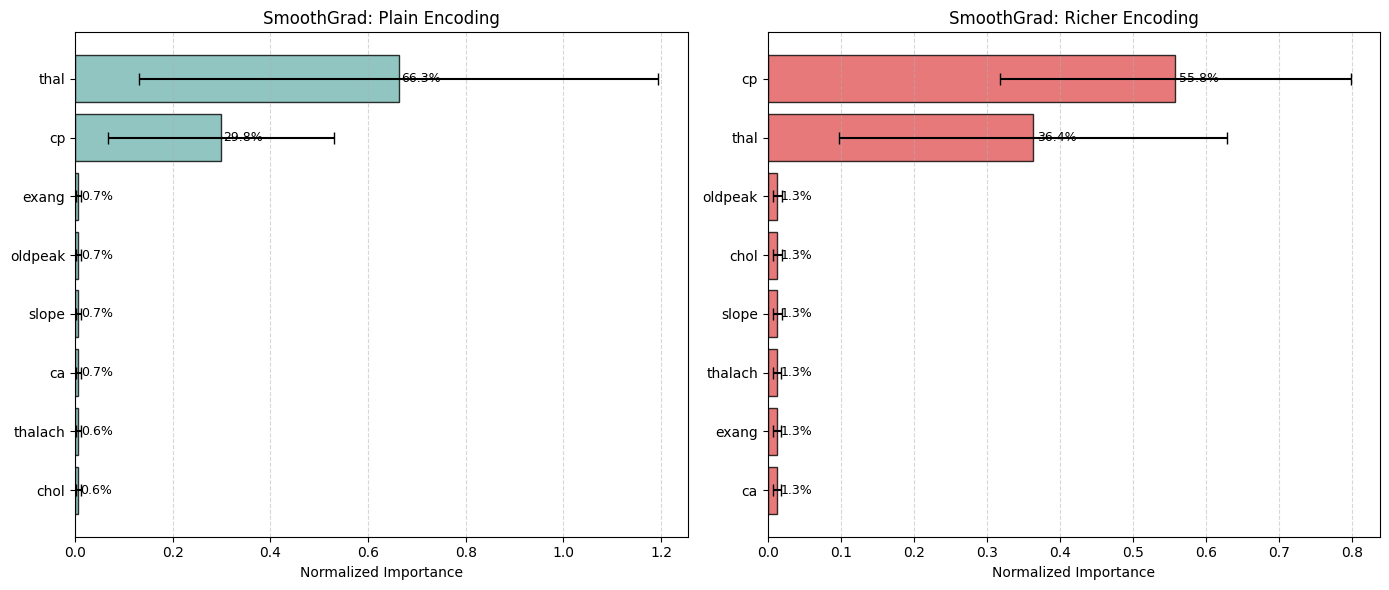

In [21]:
def compute_smoothgrad(model, X_data, K=30, sigma=0.1):
    """
    Computes SmoothGrad by averaging gradients over K noisy samples.
    Returns: Global Mean Attribution (normalized) and Standard Deviation (normalized).
    """
    model.eval()
    
    # Store accumulated gradients
    # We use a numpy array to accumulate since we don't need the graph anymore
    total_gradients = np.zeros(X_data.shape, dtype=np.float32)
    
    # Loop over K noise samples
    for k in range(K):
        # 1. Add Gaussian Noise to the batch
        noise = torch.randn_like(X_data) * sigma
        x_noisy = X_data + noise
        
        # 2. Enable Gradient Tracking for the noisy input
        x_noisy = x_noisy.clone().detach().requires_grad_(True)
        
        # 3. Forward & Backward
        output = model(x_noisy)
        model.zero_grad()
        output.sum().backward()
        
        # 4. Accumulate (Absolute value helps avoid cancellation)
        if x_noisy.grad is not None:
            total_gradients += np.abs(x_noisy.grad.cpu().detach().numpy())
            
    # 5. Average over K samples
    smooth_grads = total_gradients / K
    
    # 6. Aggregate globally
    mean_sg = smooth_grads.mean(axis=0)
    std_sg  = smooth_grads.std(axis=0)
    
    # 7. Normalize to sum to 1
    total = mean_sg.sum()
    return (mean_sg / total), (std_sg / total)

# ---------------------------------------------------------
# 1. Run Analysis on Both Models
# ---------------------------------------------------------
# Load models if not already present
if 'models' not in locals():
    model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
    model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)
    models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

results_sg = {}
K_samples = 30  # Number of noisy samples per input
noise_level = 0.1

for label, model_variant in models.items():
    print(f"🌊 Computing SmoothGrad for: {label} (K={K_samples}, σ={noise_level})...")
    results_sg[label] = compute_smoothgrad(model_variant, X_test, K=K_samples, sigma=noise_level)

# ---------------------------------------------------------
# 2. Visualization (Side-by-Side)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Plain Encoding': '#76b7b2', 'Richer Encoding': '#e15759'}

for ax, (label, (means, stds)) in zip(axes, results_sg.items()):
    # Sort features by importance for this specific model
    sorted_indices = np.argsort(means)[::-1]
    sorted_features = [feature_cols[i] for i in sorted_indices]
    sorted_means = means[sorted_indices]
    sorted_stds = stds[sorted_indices]

    # Create Bar Plot
    y_pos = np.arange(len(sorted_features))
    ax.barh(y_pos, sorted_means, xerr=sorted_stds, align='center', 
            color=colors[label], edgecolor='black', alpha=0.8, capsize=4)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_features)
    ax.invert_yaxis()  # Highest importance at top
    ax.set_xlabel("Normalized Importance")
    ax.set_title(f"SmoothGrad: {label}")
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Add numeric labels
    for i, v in enumerate(sorted_means):
        ax.text(v + 0.005, i, f"{v:.1%}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 🌍 Global Feature Importance (Aggregated)

This visualization summarizes the **Global Saliency** (mean absolute gradient) across all 5 random seeds.

* **Bar Height:** The average importance of the feature across all training runs.
* **Error Bars:** The standard deviation across runs. Large error bars indicate that the model's reliance on that feature changes depending on the random initialization (instability).

This is the most direct way to answer: *"Which biological features drive the model's decisions?"*


Aggregating Global Importance for: Plain Encoding...


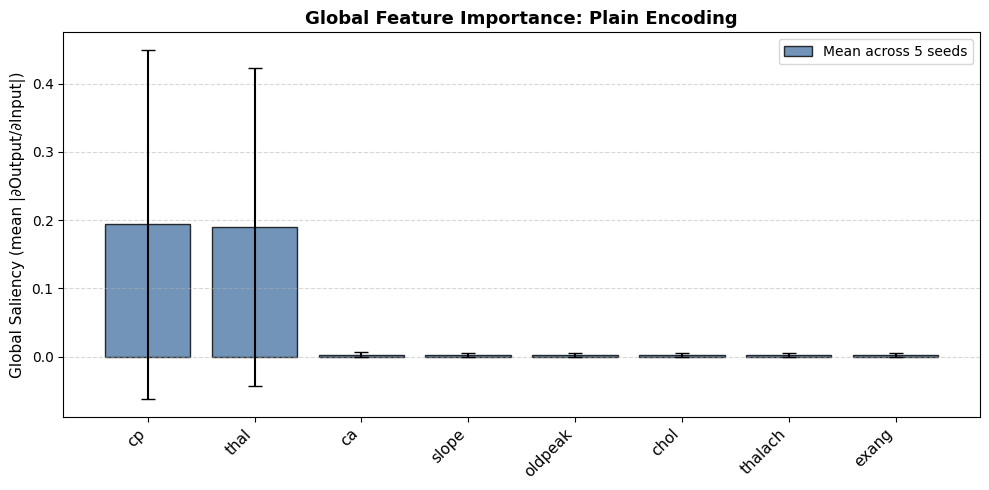


Aggregating Global Importance for: Richer Encoding...


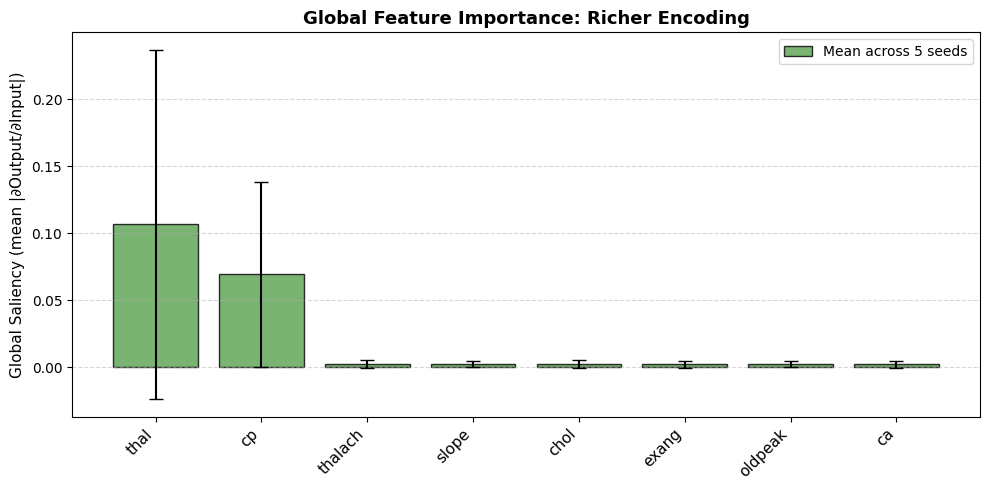

In [22]:
def plot_aggregated_importance(globs_np, title, color_code):
    """
    Plots the mean global saliency with error bars representing stability across seeds.
    globs_np shape: (num_seeds, num_features)
    """
    # 1. Compute Mean and Std across seeds
    mean_saliency = globs_np.mean(axis=0)
    std_saliency  = globs_np.std(axis=0)

    # 2. Sort for better visualization
    sorted_idx = np.argsort(mean_saliency)[::-1]
    sorted_features = [feature_cols[i] for i in sorted_idx]
    sorted_means = mean_saliency[sorted_idx]
    sorted_stds  = std_saliency[sorted_idx]

    # 3. Setup Plot
    x_indices = np.arange(len(sorted_features))
    
    plt.figure(figsize=(10, 5))

    # 4. Create Bar Chart
    plt.bar(x_indices, sorted_means, 
            yerr=sorted_stds, 
            capsize=5, 
            color=color_code, 
            edgecolor='black', 
            alpha=0.8,
            label=f"Mean across {globs_np.shape[0]} seeds")

    # 5. Formatting
    plt.xticks(x_indices, sorted_features, rotation=45, ha='right', fontsize=11)
    plt.ylabel("Global Saliency (mean |∂Output/∂Input|)", fontsize=11)
    plt.title(title, fontsize=13, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# Reuse the data from the Stability Loop
# ---------------------------------------------------------

configs = [("Plain Encoding", False, '#4e79a7'), ("Richer Encoding", True, '#59a14f')]

for label, use_richer, color in configs:
    print(f"\nAggregating Global Importance for: {label}...")
    
    # We collect the global saliency vectors from the stability runs
    local_globs = []
    for s in STABILITY_SEEDS:
        _, glob = run_training_seed(s, use_richer, epochs=3)
        local_globs.append(glob)
        
    globs_np = np.stack(local_globs)
    
    # Plot
    plot_aggregated_importance(globs_np, title=f"Global Feature Importance: {label}", color_code=color)

### ✂️ Deletion Metric (Faithfulness of Saliency)

The **Deletion Metric** evaluates **how faithfully the saliency map reflects the model’s true decision process**.

* **Purpose:**
  If a saliency method correctly identifies the most important features, then **removing those features should significantly reduce the model's confidence** in the correct class.

* **Method:**
  1. Rank features for each sample by saliency (highest $\rightarrow$ lowest importance).
  2. Iteratively delete the top-*k* most salient features by replacing them with a baseline value (usually zero).
  3. Measure how much the model’s **true-class probability** decreases as more salient features are removed.
  4. Repeat for *k = 1 … N* and average across the dataset.

* **Interpretation:**
  * A **good saliency method** produces a **steep deletion curve**: removing the "most important" features should cause a sharp drop in confidence.
  * A **flat curve** indicates that the features flagged as "important" do **not** actually drive the model's prediction.
  * Comparing deletion curves for the **Plain** vs. **Richer Encoding** models reveals which architecture relies more transparently on its top features.

* **Visualization:**
  The plot shows:
  * **x-axis:** Number of top-salient features removed.
  * **y-axis:** Average probability remaining for the true class.

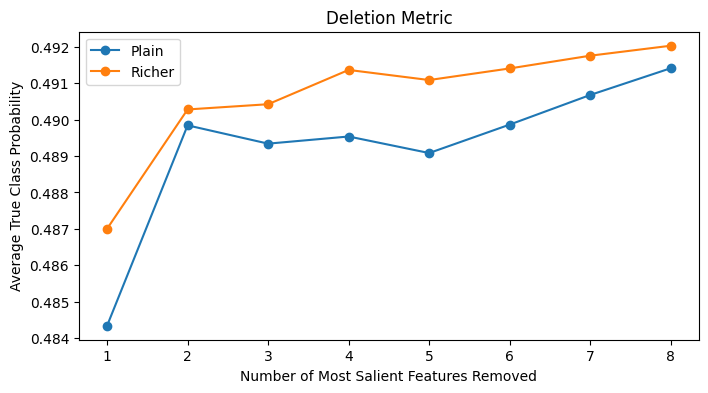

In [23]:
def deletion_score(model, inputs, labels, saliency, steps=5):
    inputs_copy = inputs.clone()
    labels_np = labels.numpy()
    scores = []

    for k in range(1, steps+1):
        topk = np.argsort(-saliency, axis=1)[:, :k]
        modified = inputs_copy.clone()
        
        for i in range(modified.shape[0]):
            modified[i, topk[i]] = 0.0
        
        with torch.no_grad():
            outputs = model(modified)  # shape (n_samples, 1)
            probs = torch.sigmoid(outputs).numpy().flatten()  # probability of class 1
            true_class_probs = np.where(labels_np==1, probs, 1-probs)
        
        scores.append(true_class_probs.mean())
    
    return scores

labels_test = y_test.clone().detach().long()
deletion_plain = deletion_score(model_plain, X_test, labels_test, saliency_plain, steps=X_test.shape[1])
deletion_rich  = deletion_score(model_rich, X_test, labels_test, saliency_rich, steps=X_test.shape[1])

plt.figure(figsize=(8,4))
plt.plot(range(1, X_test.shape[1]+1), deletion_plain, marker='o', label="Plain")
plt.plot(range(1, X_test.shape[1]+1), deletion_rich, marker='o', label="Richer")
plt.xlabel("Number of Most Salient Features Removed")
plt.ylabel("Average True Class Probability")
plt.title("Deletion Metric")
plt.legend()
plt.show()

### ⚡ Comparative Global Attribution: Occlusion ($\Delta$ Loss)

In this section, we compare **Occlusion Sensitivity** for both the Plain and Richer encoding models.

This method is model-agnostic and intuitive. It asks: *"If I delete this feature (replace it with zero), how much worse does the model's prediction get?"*

We measure the increase in **Binary Cross Entropy (BCE) Loss** when a specific feature is "occluded" (zeroed out) across the entire test set.

$$\text{Importance}_i = \text{Loss}(X_{\text{occluded}, i}) - \text{Loss}(X_{\text{original}})$$

* **High Positive $\Delta$ Loss:** The feature was crucial; removing it caused the model's error to spike.
* **Near-Zero $\Delta$ Loss:** The feature was irrelevant to the prediction.
* **Negative $\Delta$ Loss:** The feature was actually confusing the model (noise), and removing it improved performance.



**Goal:**
By comparing the "Δ Loss" profiles side-by-side, we can determine if the **Richer Encoding** becomes more dependent on specific clinical features compared to the **Plain Encoding**, or if it distributes its reliance more evenly across inputs.

🚫 Computing Occlusion Δ Loss for: Plain Encoding...
🚫 Computing Occlusion Δ Loss for: Richer Encoding...


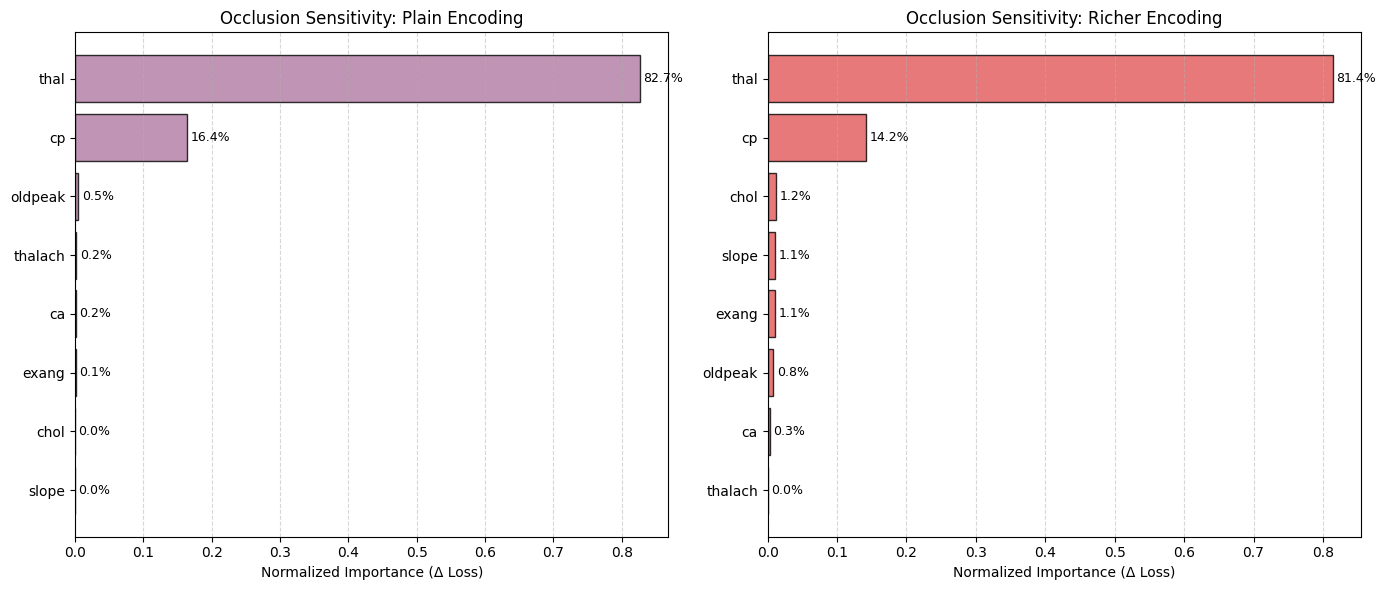

In [24]:
def compute_occlusion_loss(model, X_data, y_data):
    """
    Computes Feature Importance via Occlusion (Leave-One-Out).
    Metric: Increase in Binary Cross Entropy Loss.
    """
    model.eval()
    criterion = torch.nn.BCEWithLogitsLoss()
    
    # 1. Compute Baseline Loss (with all features present)
    with torch.no_grad():
        preds_base = model(X_data)
        loss_base = criterion(preds_base, y_data).item()
    
    importances = []
    
    # 2. Iterate over each feature
    num_features = X_data.shape[1]
    
    for i in range(num_features):
        # Create a copy of input data
        X_occ = X_data.clone().detach()
        
        # Occlude feature i (replace with 0.0)
        X_occ[:, i] = 0.0
        
        # Compute Loss on occluded data
        with torch.no_grad():
            preds_occ = model(X_occ)
            loss_occ = criterion(preds_occ, y_data).item()
            
        # Importance = Increase in Loss (ReLU applied to ignore improvements)
        delta_loss = loss_occ - loss_base
        importances.append(max(0.0, delta_loss))
        
    return np.array(importances)

results_occ = {}

for label, model_variant in models.items():
    print(f"🚫 Computing Occlusion Δ Loss for: {label}...")
    results_occ[label] = compute_occlusion_loss(model_variant, X_test, y_test)

# ---------------------------------------------------------
# Visualization (Side-by-Side)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Plain Encoding': '#b07aa1', 'Richer Encoding': '#e15759'} # Purple vs Red

for ax, (label, imp_scores) in zip(axes, results_occ.items()):
    # Normalize for visualization (relative % contribution to total error increase)
    if imp_scores.sum() > 0:
        imp_norm = imp_scores / imp_scores.sum()
    else:
        imp_norm = imp_scores

    # Sort features by importance
    sorted_indices = np.argsort(imp_norm)[::-1]
    sorted_features = [feature_cols[i] for i in sorted_indices]
    sorted_vals = imp_norm[sorted_indices]

    # Create Bar Plot
    y_pos = np.arange(len(sorted_features))
    ax.barh(y_pos, sorted_vals, align='center', 
            color=colors[label], edgecolor='black', alpha=0.8)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_features)
    ax.invert_yaxis()  # Highest importance at top
    ax.set_xlabel("Normalized Importance (Δ Loss)")
    ax.set_title(f"Occlusion Sensitivity: {label}")
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Add numeric labels
    for i, v in enumerate(sorted_vals):
        ax.text(v + 0.005, i, f"{v:.1%}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 📈 Minimum Efficacy (Saliency Beyond Confidence)

The **Minimum Efficacy** metric evaluates whether the saliency maps provide **additional explanatory power** about the model's correctness, beyond just looking at the model's raw confidence score.

* **Purpose:**
    Does the "strength" of the explanation help us predict if the model is right or wrong?
    * Ideally, when the model is confused (likely to be wrong), the saliency map might look "scattered" or weak.
    * We want to know if the saliency map adds value (trust) or if we should just rely on the confidence score alone.

* **Method:**
    1.  We classify every test sample as **Correct** or **Incorrect** based on the model's prediction.
    2.  We calculate the **AUC (Area Under Curve)** for two signals:
        * **Confidence AUC:** How well does the *prediction probability* separate correct from incorrect samples?
        * **Saliency AUC:** How well does the *mean saliency magnitude* separate correct from incorrect samples?
    3.  **Saliency Gain** = `AUC(Saliency) - AUC(Confidence)`

* **Interpretation:**
    * **Positive Gain:** The saliency map provides *extra* insight. It can detect potential errors that the confidence score misses.
    * **Negative Gain:** The raw confidence score is a better predictor of accuracy than the explanation is.
    * **NaN (Not a Number):** This occurs if the model is **100% accurate** (or 100% wrong) on the test batch.
        * If there are no "incorrect" samples to detect, the AUC cannot be calculated.
        * **This is not an error**; it simply means the model is too perfect on this specific dataset to measure error-detection capability.

In [25]:
def safe_roc_auc(y_true, y_score):
    if len(np.unique(y_true)) < 2:
        return float('nan')
    return roc_auc_score(y_true, y_score)

def minimum_efficacy(model, inputs, labels, saliency):
    with torch.no_grad():
        # Ensure outputs is 1D array (Length N)
        outputs = model(inputs).detach().cpu().numpy().ravel()
        probs = torch.sigmoid(torch.tensor(outputs)).numpy()
        
    # Ensure labels_np is 1D array (Length N)
    labels_np = labels.detach().cpu().numpy().ravel() if torch.is_tensor(labels) else np.asarray(labels).ravel()

    # Predictions (Length N)
    preds = (probs >= 0.5).astype(int)

    # Correctness indicator (Length N)
    correct = (preds == labels_np).astype(int)
    
    # Confidence in prediction (Length N)
    pred_conf = np.where(preds == 1, probs, 1 - probs)

    # Ensure all final inputs are flattened one last time (though should be 1D here)
    correct = correct.ravel()
    pred_conf = pred_conf.ravel()

    # Check for consistency just before calling AUC to prevent the ValueError
    if len(correct) != len(pred_conf):
        raise ValueError(f"Inconsistent sample lengths: correct={len(correct)}, pred_conf={len(pred_conf)}")

    # Proceed with AUC calculation
    auc_conf = safe_roc_auc(correct, pred_conf)
    
    # Saliency part: Ensure saliency is correctly mean-reduced to length N
    # saliency.mean(axis=1) must have length N (i.e., the batch size)
    auc_sal = safe_roc_auc(correct, saliency.mean(axis=1).ravel())

    sal_gain = auc_sal - auc_conf if not (np.isnan(auc_conf) or np.isnan(auc_sal)) else float('nan')
    return {"auc_confidence": auc_conf, "auc_saliency": auc_sal, "saliency_gain": sal_gain}

min_eff_plain = minimum_efficacy(model_plain, X_test, y_test, saliency_plain)
min_eff_rich  = minimum_efficacy(model_rich, X_test, y_test, saliency_rich)

def print_min_eff(name, result):
    print(f"--- {name} ---")
    print(f"AUC (Confidence) : {result['auc_confidence']:.4f}" if not np.isnan(result['auc_confidence']) else "AUC (Confidence) : nan")
    print(f"AUC (Saliency)   : {result['auc_saliency']:.4f}"   if not np.isnan(result['auc_saliency']) else "AUC (Saliency)   : nan")
    print(f"Saliency Gain    : {result['saliency_gain']:.4f}"   if not np.isnan(result['saliency_gain']) else "Saliency Gain    : nan\n")

print_min_eff("Plain Encoding", min_eff_plain)
print_min_eff("Richer Encoding", min_eff_rich)

--- Plain Encoding ---
AUC (Confidence) : 0.7800
AUC (Saliency)   : 0.2473
Saliency Gain    : -0.5327
--- Richer Encoding ---
AUC (Confidence) : 0.7333
AUC (Saliency)   : 0.4765
Saliency Gain    : -0.2569


### ⚠️ Overreliance Risk (Reliability of Saliency Beyond Confidence)

The **Overreliance Risk** metric evaluates **whether the saliency map provides useful information beyond the model’s raw confidence**. It helps identify if users might be misled by explanations that look convincing but don't actually reflect the model's sensitivity.

* **Purpose:**
  Even if a model is confident, a faithful saliency map should **highlight features that truly influence the prediction**.
  If a model is highly confident but removing the "top" feature causes no drop in that confidence, the explanation is misleading. We call this "Overreliance Risk."

* **Method:**
  1.  **Fidelity Check:** For each sample, remove the top salient feature ($k=1$) and measure the **drop in true-class probability** ($\text{fidelity} = P_{\text{original}} - P_{\text{deleted}}$).
  2.  **Confidence Check:** Record the model's original confidence score.
  3.  **Correlation:** Calculate the correlation between **Confidence** and **Lack of Fidelity** (how little the probability dropped).

* **Interpretation:**
  * **High Positive Risk (> 0):** The model is often highly confident, yet removing the "important" features changes nothing. This suggests the explanation is a placebo.
  * **Low/Negative Risk (< 0):** When the model is confident, removing the top feature causes a significant drop. This means the explanation faithfully points to the "load-bearing" features.

In [26]:
def deletion_fidelity_per_sample(model, inputs, saliency, labels, k=1):
    N, F = inputs.shape

    # ensure labels are integer tensor
    if not torch.is_tensor(labels):
        labels = torch.tensor(labels, dtype=torch.long)
    labels = labels.to(inputs.device)

    with torch.no_grad():
        outputs = model(inputs).flatten()            # shape: (N,)
        probs = torch.sigmoid(outputs)              # probability of class 1
        base_conf = probs.cpu().numpy()             # shape: (N,)

    fidelity = np.zeros(N)

    for i in range(N):
        topk = np.argsort(-saliency[i])[:k]         # top-k features
        x_mod = inputs[i].clone()
        x_mod[topk] = 0.0

        with torch.no_grad():
            out = model(x_mod.unsqueeze(0)).flatten()
            prob = torch.sigmoid(out).item()

        # confidence drop for true class
        true_label = labels[i].item()
        if true_label == 1:
            fidelity[i] = base_conf[i] - prob
        else:
            fidelity[i] = (1 - base_conf[i]) - (1 - prob)

    return fidelity


def overreliance_risk(confidence, fidelity):
    return np.corrcoef(confidence, -fidelity)[0, 1]


# --- Compute fidelity ---
fidelity_plain = deletion_fidelity_per_sample(model_plain, X_test, saliency_plain, y_test, k=1)
fidelity_rich  = deletion_fidelity_per_sample(model_rich,  X_test, saliency_rich,  y_test, k=1)

# --- Compute confidence per sample ---
with torch.no_grad():
    conf_plain = torch.sigmoid(model_plain(X_test).flatten()).cpu().numpy()
    conf_rich  = torch.sigmoid(model_rich(X_test).flatten()).cpu().numpy()

# --- Compute overreliance risk ---
risk_plain = overreliance_risk(conf_plain, fidelity_plain)
risk_rich  = overreliance_risk(conf_rich, fidelity_rich)

print("Overreliance Risk (Plain):", risk_plain)
print("Overreliance Risk (Rich):",  risk_rich)

Overreliance Risk (Plain): -0.6500894306177838
Overreliance Risk (Rich): -0.6155564469983654


### ⚡ Comparative Global Attribution: Noise Sensitivity

In this section, we compare **Noise Sensitivity** for both models.

This metric is distinct from gradient-based methods. Instead of looking at the slope (gradient), it empirically tests stability: *"If I wiggle this one feature a little bit, does the prediction jump around or stay stable?"*

We measure the expected change in the model's output score $| \Delta z |$ when a single feature $x_j$ is perturbed by Gaussian noise $\mathcal{N}(0, \sigma^2)$, while holding all other features constant.

$$\text{Sensitivity}_j = \mathbb{E}[|F(x + \delta_j) - F(x)|]$$

* **High Sensitivity:** The model is "jittery" or highly reactive to this specific feature. Small changes lead to large output swings.
* **Low Sensitivity:** The model is robust or indifferent to changes in this feature.



**Goal:**
We want to see if the **Richer Encoding** (which is more complex) is *more sensitive* to input noise (indicating potential overfitting or high-frequency behavior) or if it maintains robustness compared to the **Plain Encoding**.

〰️ Computing Noise Sensitivity for: Plain Encoding (σ=0.1, K=50)...
〰️ Computing Noise Sensitivity for: Richer Encoding (σ=0.1, K=50)...


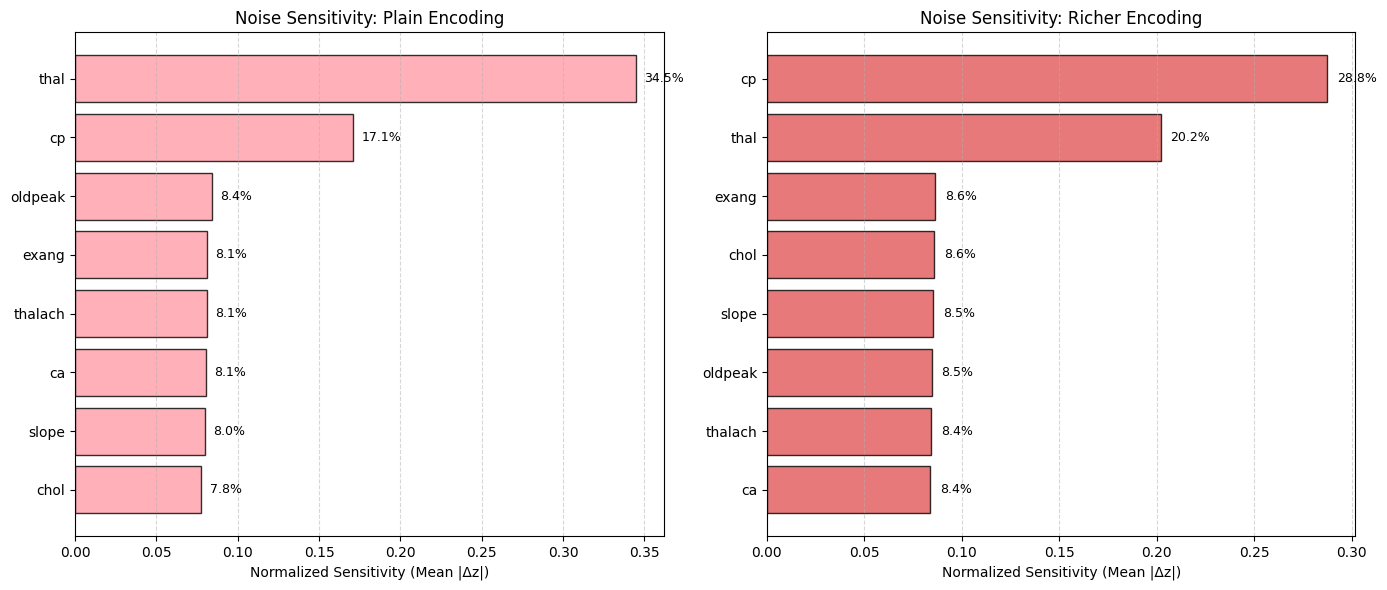

In [27]:
def compute_noise_sensitivity(model, X_data, sigma=0.1, K=50):
    """
    Computes Noise Sensitivity per feature.
    Metric: Mean absolute change in output score when feature j is perturbed.
    """
    model.eval()
    
    # 1. Compute Base Outputs
    with torch.no_grad():
        # Shape: (N, 1) -> Flatten to (N,)
        base_preds = model(X_data).view(-1).cpu().numpy()
    
    num_features = X_data.shape[1]
    num_samples = X_data.shape[0]
    
    # Store sensitivity per feature (averaged over dataset)
    sensitivity_scores = np.zeros(num_features)
    
    # 2. Iterate over features
    for j in range(num_features):
        diffs_accum = np.zeros(num_samples)
        
        # Monte Carlo sampling for noise
        for _ in range(K):
            # Create perturbed batch
            noise = torch.randn(num_samples) * sigma
            X_noisy = X_data.clone().detach()
            
            # Perturb only feature j
            X_noisy[:, j] += noise.to(X_data.device)
            
            with torch.no_grad():
                preds_noisy = model(X_noisy).view(-1).cpu().numpy()
                
            # Accumulate absolute difference
            diffs_accum += np.abs(preds_noisy - base_preds)
            
        # Average over K noise samples
        mean_diff = diffs_accum / K
        
        # Average over the dataset (Global Sensitivity for feature j)
        sensitivity_scores[j] = mean_diff.mean()
        
    return sensitivity_scores

# ---------------------------------------------------------
# 1. Run Analysis on Both Models
# ---------------------------------------------------------
# Load models if not already present
if 'models' not in locals():
    model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
    model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)
    models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

results_ns = {}
NOISE_SIGMA = 0.1
NOISE_K = 50

for label, model_variant in models.items():
    print(f"〰️ Computing Noise Sensitivity for: {label} (σ={NOISE_SIGMA}, K={NOISE_K})...")
    results_ns[label] = compute_noise_sensitivity(model_variant, X_test, sigma=NOISE_SIGMA, K=NOISE_K)

# ---------------------------------------------------------
# 2. Visualization (Side-by-Side)
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = {'Plain Encoding': '#ff9da7', 'Richer Encoding': '#e15759'} # Pink vs Red

for ax, (label, sens_scores) in zip(axes, results_ns.items()):
    # Normalize for visualization (relative share of total sensitivity)
    if sens_scores.sum() > 0:
        sens_norm = sens_scores / sens_scores.sum()
    else:
        sens_norm = sens_scores

    # Sort features by sensitivity
    sorted_indices = np.argsort(sens_norm)[::-1]
    sorted_features = [feature_cols[i] for i in sorted_indices]
    sorted_vals = sens_norm[sorted_indices]

    # Create Bar Plot
    y_pos = np.arange(len(sorted_features))
    ax.barh(y_pos, sorted_vals, align='center', 
            color=colors[label], edgecolor='black', alpha=0.8)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_features)
    ax.invert_yaxis()  # Highest sensitivity at top
    ax.set_xlabel("Normalized Sensitivity (Mean |Δz|)")
    ax.set_title(f"Noise Sensitivity: {label}")
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Add numeric labels
    for i, v in enumerate(sorted_vals):
        ax.text(v + 0.005, i, f"{v:.1%}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 📊 Saliency Entropy (Complexity of Explanations)

The **Saliency Entropy** metric measures **how spread out or concentrated the feature importance is across input features**, providing a complementary view to sparsity.

* **Purpose:**
  Entropy captures the **overall complexity** of the saliency distribution:

  * Low entropy → most importance is concentrated on a few features → simple and concise explanations
  * High entropy → importance is spread across many features → more complex and potentially harder to interpret explanations

* **Method:**

  1. Compute the **mean saliency** for each feature across all samples.
  2. Normalize to get a probability distribution.
  3. Compute the **Shannon entropy** of this distribution:

  $$
  H = - \sum_i p_i \log(p_i)
  $$

* **Interpretation:**

  * **Low entropy** → explanations are focused, highlighting a few key features.
  * **High entropy** → explanations are distributed, indicating the model relies on multiple features or has entangled representations.
  * Comparing **plain** vs **richer encoding** models shows which produces simpler, more concise explanations. As we can observe, while the entropies are similar, the plain encoding produces a lower entropy and thus leading to a simpler and more concise explanation.

In [28]:
def saliency_entropy(saliency):
    mean_sal = saliency.mean(axis=0)
    p = mean_sal / (mean_sal.sum() + 1e-12)
    return entropy(p)

entropy_plain = saliency_entropy(saliency_plain)
entropy_rich  = saliency_entropy(saliency_rich)

print("Entropy (Plain):", entropy_plain)
print("Entropy (Richer):", entropy_rich)

Entropy (Plain): 2.0726507
Entropy (Richer): 2.0752678


### 🧩 Saliency Sparseness (Conciseness of Explanations)

The **Saliency Sparseness** metric evaluates **how concentrated or distributed the saliency values are across input features**.

* **Purpose:**
  A sparse explanation highlights a **small number of highly important features**, which can improve interpretability and make explanations easier for humans to understand.
  Conversely, a dense explanation spreads importance across many features, making it harder to discern which features truly matter.

* **Method:**

  1. Compute the **L1 norm** of the saliency map (sum of absolute values).
  2. Compute the **L2 norm** of the saliency map (square root of sum of squares).
  3. Define sparsity as:

$$
\text{Sparsity} = \frac{||\text{saliency}||_1}{||\text{saliency}||_2 + \epsilon}
$$

  * Lower values indicate **higher sparsity** (more focused explanations).
  * Higher values indicate **less sparse** explanations (spread-out feature importance).

* **Interpretation:**

  * **Low Sparseness** → the model’s saliency focuses on a few key features → easier to understand and trust.
  * **High Sparseness** → the model distributes importance across many features → may indicate redundant or entangled feature use.
  * Comparing the **plain** vs **richer encoding** models shows whether richer representations produce more concentrated or more distributed explanations. We observe that the plain encoding has a more concentrated explanation.

In [29]:
def saliency_sparseness(saliency):
    l1 = np.sum(np.abs(saliency))
    l2 = np.sqrt(np.sum(saliency**2))
    return l1 / (l2 + 1e-12)

sparse_plain = saliency_sparseness(saliency_plain)
sparse_rich  = saliency_sparseness(saliency_rich)

print("Sparseness (Plain):", sparse_plain)
print("Sparseness (Rich):", sparse_rich)

Sparseness (Plain): 13.425935
Sparseness (Rich): 14.305616


### 🧠 Quantum Embedding Visualization (PCA)

This section visualizes the **quantum layer outputs** in 2D using **Principal Component Analysis (PCA)**:

- Each point represents a test sample in the **quantum feature space**.  
- Color corresponds to the **true class** of the sample.  
- Comparing the two plots shows how the **plain vs richer encoding** affects the separation of classes:
  - **Plain Encoding:** simpler mapping, possibly more overlapping clusters.  
  - **Richer Encoding:** extra RZ rotations provide a more expressive embedding, which can lead to better class separation.  

This visualization helps intuitively understand why richer encoding may improve classification performance.

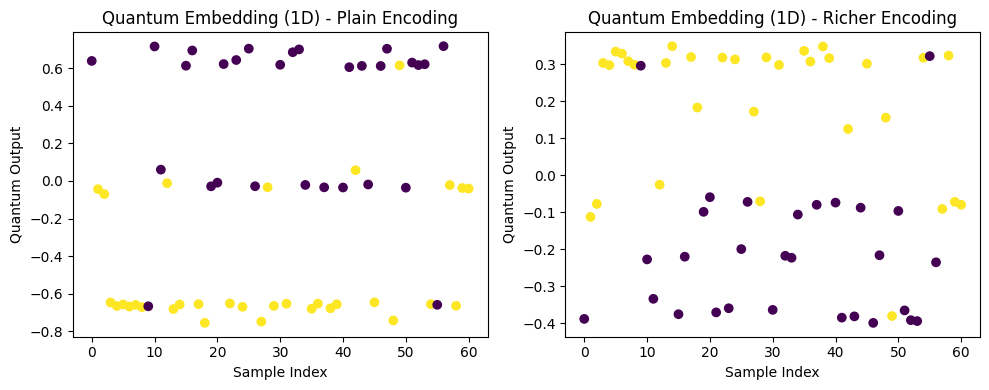

In [30]:
def visualize_latent_1d(model, name):
    with torch.no_grad():
        latent = model.qlayer(X_test).detach().cpu().numpy().flatten()  # shape: (num_samples,)
    
    y_np = y_test.detach().cpu().numpy() if torch.is_tensor(y_test) else y_test

    plt.scatter(range(len(latent)), latent, c=y_np, cmap='viridis')
    plt.title(f"Quantum Embedding (1D) - {name}")
    plt.xlabel("Sample Index")
    plt.ylabel("Quantum Output")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
visualize_latent_1d(model_plain, "Plain Encoding")
plt.subplot(1,2,2)
visualize_latent_1d(model_rich, "Richer Encoding")
plt.tight_layout()
plt.show()

### 🗺️ Decision Surface & Confusion Matrix

This section visualizes the "brain" of the quantum model by combining two powerful views:

1.  **Decision Surface (Top Row):**
    We visualize the model's decision boundary by projecting the high-dimensional data onto the **top-2 most important features** (identified via global saliency).
    * **Blue Region:** Model predicts Class 0 (Low Risk/Negative).
    * **Red Region:** Model predicts Class 1 (High Risk/Positive).
    * **Scatter Points:** Real test data plotted on top.
        * If a **Red Square** (Class 1) lands in the **Blue Zone**, it represents a *False Negative*.
        * If a **Blue Square** (Class 0) lands in the **Red Zone**, it represents a *False Positive*.

2.  **Confusion Matrix (Bottom Row):**
    A quantitative count of correct and incorrect predictions on the Test Set.
    * **Diagonal:** Correct predictions (True Negatives, True Positives).
    * **Off-Diagonal:** Errors (False Positives, False Negatives).



**Goal:**
Does the **Richer Encoding** create a more complex, non-linear boundary (curved lines) compared to the **Plain Encoding**, allowing it to better separate difficult cases? Or does the simpler model suffice?

📍 Plain Encoding: Plotting Decision Surface for features 'cp' & 'thal'
📍 Richer Encoding: Plotting Decision Surface for features 'cp' & 'thal'


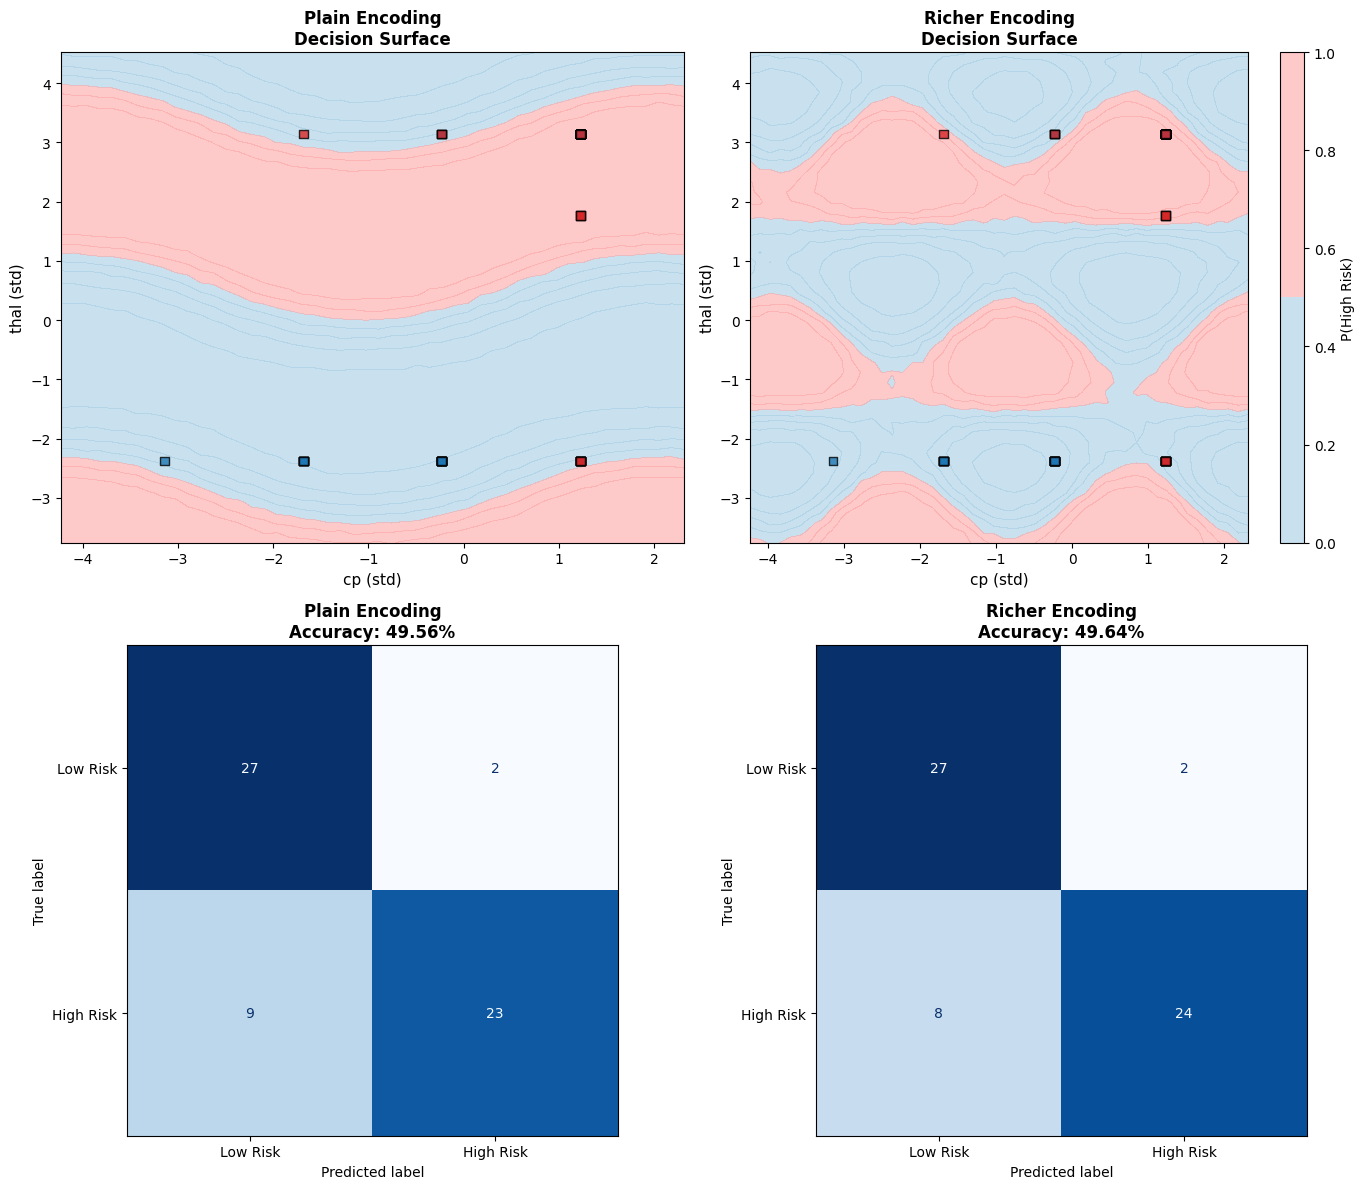

In [32]:
# ===== Decision Surface & Confusion Matrix (Fixed) =====
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
import torch
import numpy as np
import matplotlib.pyplot as plt

def get_decision_grid(model, X_ref, f1_idx, f2_idx, n_points=50, margin=0.25):
    """
    Generates a 2D grid of probabilities for the decision surface.
    Non-active features are set to 0 (baseline).
    """
    model.eval()
    
    # 1. Determine ranges for the two active features
    f1_min, f1_max = X_ref[:, f1_idx].min(), X_ref[:, f1_idx].max()
    f2_min, f2_max = X_ref[:, f2_idx].min(), X_ref[:, f2_idx].max()
    
    dx1, dx2 = f1_max - f1_min, f2_max - f2_min
    f1_min -= margin * dx1; f1_max += margin * dx1
    f2_min -= margin * dx2; f2_max += margin * dx2
    
    # 2. Create Grid
    xx, yy = np.meshgrid(np.linspace(f1_min, f1_max, n_points),
                         np.linspace(f2_min, f2_max, n_points))
    
    # 3. Construct Input Batch
    # Initialize all features to 0.0
    grid_tensor = torch.zeros((n_points * n_points, X_ref.shape[1]))
    
    # Fill in the active features from the meshgrid
    grid_tensor[:, f1_idx] = torch.tensor(xx.ravel(), dtype=torch.float32)
    grid_tensor[:, f2_idx] = torch.tensor(yy.ravel(), dtype=torch.float32)
    
    # 4. Batch Prediction
    # We predict in chunks to avoid memory issues if n_points is huge
    probs = []
    chunk_size = 1000
    with torch.no_grad():
        for i in range(0, len(grid_tensor), chunk_size):
            batch = grid_tensor[i : i+chunk_size]
            outputs = model(batch)
            probs.append(torch.sigmoid(outputs).cpu().numpy())
            
    probs = np.concatenate(probs).reshape(xx.shape)
    return xx, yy, probs

# ---------------------------------------------------------
# Visualization Setup
# ---------------------------------------------------------

# 1. Load Models if needed
if 'models' not in locals():
    # Make sure these paths match your actual saved model paths
    model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
    model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)
    models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

# 2. Handle Data Availability (The Fix)
# We need a reference dataset to define the min/max range for the plot.
# If X_train_tensor is missing, we try X_train (numpy), or fallback to X_test.

if 'X_train_tensor' in locals():
    X_ref_np = X_train_tensor.cpu().numpy()
elif 'X_train' in locals():
    X_ref_np = X_train # Assuming it's already numpy
else:
    print("⚠️ Training data not found. Using Test data for decision boundary ranges.")
    X_ref_np = X_test.cpu().numpy() # Fallback

# Ensure Test data is numpy for plotting
X_test_np = X_test.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# ---------------------------------------------------------
# Plotting Loop
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Custom Colormaps
cmap_contour = ListedColormap(["#A6CEE3", "#FCA5A5"]) # Light Blue, Light Red
cmap_points  = ListedColormap(["#1f77b4", "#d62728"]) # Dark Blue, Dark Red

for i, (label, model_variant) in enumerate(models.items()):
    
    # --- A. Identify Top 2 Features ---
    # We reuse compute_grad_x_input. If not defined, define it or use a placeholder.
    # Assuming compute_grad_x_input is available from previous cells.
    try:
        attributions, _ = compute_grad_x_input(model_variant, X_test) 
        top2_idx = np.argsort(attributions)[-2:]
    except NameError:
        # Fallback if the function isn't in memory: Pick first two features
        print("⚠️ 'compute_grad_x_input' not found. Using first 2 features.")
        top2_idx = [0, 1]
        
    f1, f2 = top2_idx[0], top2_idx[1] # Features to plot
    
    print(f"📍 {label}: Plotting Decision Surface for features '{feature_cols[f1]}' & '{feature_cols[f2]}'")

    # --- B. Generate Decision Grid ---
    xx, yy, P_grid = get_decision_grid(model_variant, X_ref_np, f1, f2)
    
    # --- C. Plot Decision Surface (Top Row) ---
    ax_surf = axes[0, i]
    
    # Contour
    contour = ax_surf.contourf(xx, yy, P_grid, levels=np.linspace(0, 1, 11), 
                               cmap=cmap_contour, alpha=0.6)
    if i == 1: plt.colorbar(contour, ax=ax_surf, label="P(High Risk)")
    
    # Scatter (Test Data Only for clarity)
    scatter = ax_surf.scatter(X_test_np[:, f1], X_test_np[:, f2], c=y_test_np, 
                              cmap=cmap_points, edgecolors='k', s=40, marker='s', alpha=0.8, label='Test Data')
    
    ax_surf.set_xlabel(f"{feature_cols[f1]} (std)", fontsize=11)
    ax_surf.set_ylabel(f"{feature_cols[f2]} (std)", fontsize=11)
    ax_surf.set_title(f"{label}\nDecision Surface", fontweight='bold')
    
    # --- D. Plot Confusion Matrix (Bottom Row) ---
    ax_cm = axes[1, i]
    
    # Get predictions
    with torch.no_grad():
        logits = model_variant(X_test)
        preds = (torch.sigmoid(logits) >= 0.5).float().cpu().numpy()
    
    acc = (preds.flatten() == y_test_np).mean() * 100
    
    # Plot CM
    cm = confusion_matrix(y_test_np, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Risk", "High Risk"])
    disp.plot(ax=ax_cm, cmap="Blues", colorbar=False)
    
    ax_cm.set_title(f"{label}\nAccuracy: {acc:.2f}%", fontweight='bold')

plt.tight_layout()
plt.show()

### 📈 Partial Dependence (PDP) at the Mean

This visualization isolates the **marginal effect** of the most important features on the model's prediction. It answers the question: *"How does the prediction change as we vary just this one feature, while holding all others constant at their average?"*

* **X-axis:** The value of the specific feature (ranging from low to high).
* **Y-axis:** The predicted probability of "High Risk" (Class 1).

**Interpretation:**
* **Steep Sigmoid Curve:** The feature is a strong driver. Small changes in this value rapidly flip the model's decision from Class 0 to Class 1.
* **Flat Line:** The feature has little effect *on average* (or its effect depends heavily on interactions with other features that are currently fixed).



**Goal:**
We want to see if the **Richer Encoding** learns sharper, more distinct decision boundaries (steeper curves) for critical features compared to the **Plain Encoding**, or if it captures more complex non-linear relationships.

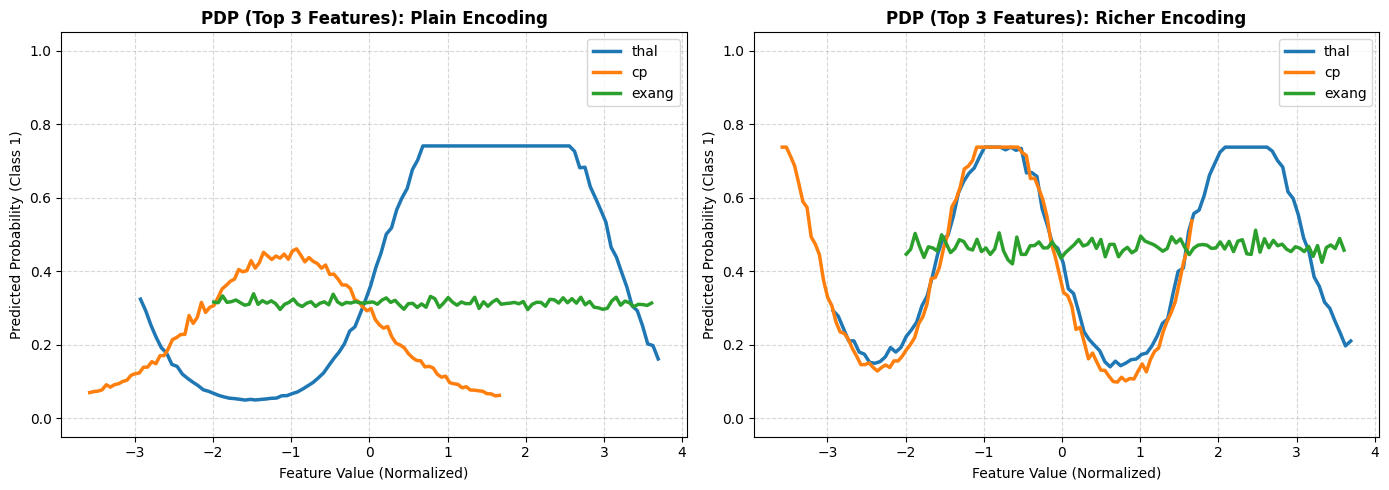

In [35]:
def compute_pdp_at_mean(model, X_ref, feature_idx, steps=100, margin=0.1):
    """
    Computes the partial dependence of the prediction on a single feature,
    holding all other features fixed at their global mean.
    """
    model.eval()
    
    # 1. Setup Range for the Feature
    f_min = X_ref[:, feature_idx].min().item()
    f_max = X_ref[:, feature_idx].max().item()
    span = f_max - f_min
    
    # Create a range extending slightly beyond min/max
    xs = np.linspace(f_min - margin*span, f_max + margin*span, steps)
    
    # 2. Create "Average Sample" Template
    # We take the mean of every feature to create a baseline input
    template = X_ref.mean(dim=0).unsqueeze(0) # Shape: (1, n_features)
    
    # 3. Create Batch
    # We replicate the template 'steps' times
    batch = template.repeat(steps, 1) # Shape: (steps, n_features)
    
    # Overwrite the target feature column with our range values
    batch[:, feature_idx] = torch.tensor(xs, dtype=torch.float32)
    
    # 4. Predict
    with torch.no_grad():
        logits = model(batch)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        
    return xs, probs

# ---------------------------------------------------------
# Visualization (Side-by-Side)
# ---------------------------------------------------------

# 1. Load Models if needed
if 'models' not in locals():
    model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
    model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)
    models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

# 2. Handle Data Availability & Type Safely
# This block fixes the UserWarning by checking the type first

if 'X_train_tensor' in locals():
    # If explicitly defined as tensor, just clone it to be safe
    X_ref_tensor = X_train_tensor.clone().detach().float()
elif 'X_train' in locals():
    # Check if X_train is already a tensor or numpy
    if isinstance(X_train, torch.Tensor):
        X_ref_tensor = X_train.clone().detach().float()
    else:
        # It's a numpy array, safe to use torch.tensor()
        X_ref_tensor = torch.tensor(X_train).float()
else:
    print("⚠️ Training data not found. Using Test data for PDP ranges.")
    if isinstance(X_test, torch.Tensor):
        X_ref_tensor = X_test.clone().detach().float()
    else:
        X_ref_tensor = torch.tensor(X_test).float()

# ---------------------------------------------------------
# Plotting Loop
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (label, model_variant) in zip(axes, models.items()):
    
    # 1. Identify Top 3 Features to Plot
    if 'results' in locals() and label in results:
        means, _ = results[label]
        top_indices = np.argsort(means)[::-1][:3] # Top 3
    else:
        top_indices = [0, 1, 2] # Fallback

    # 2. Plot Curves
    for idx in top_indices:
        feat_name = feature_cols[idx]
        xs, ps = compute_pdp_at_mean(model_variant, X_ref_tensor, idx)
        
        ax.plot(xs, ps, linewidth=2.5, label=f"{feat_name}")

    # 3. Formatting
    ax.set_title(f"PDP (Top 3 Features): {label}", fontweight='bold')
    ax.set_xlabel("Feature Value (Normalized)")
    ax.set_ylabel("Predicted Probability (Class 1)")
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

### ⚡ Parameter Sensitivity Analysis (Gradients)

This section evaluates how sensitive the model outputs are to changes in the **trainable parameters** of both the quantum and classical layers.

- **Gradient Magnitude:**
  - We compute the gradient of the loss with respect to each parameter tensor on the test set.
  - **Larger gradients** indicate parameters that strongly influence the model’s predictions (the model is "sensitive" to these weights).
  - **Smaller gradients** suggest parameters that have settled or are less critical for the current decision boundary.

- **Purpose:**
  - Compare **Plain vs. Richer Encoding** to see how the added complexity affects the learning landscape.
  - Do the **Quantum Parameters** (inside the circuit) carry more "weight" in the decision process than the **Classical Post-processing** layers?

- **Visualization:**
  - Each bar represents the **average absolute gradient** for a specific parameter group:
    1.  **Quantum Weights ($\theta$):** The rotation angles in the parameterized quantum circuit (VQC). These control the quantum state preparation and feature transformation.
    2.  **Classical Weights:** The weights of the final linear layer (Fully Connected) that map the quantum measurements to a class probability.
    3.  **Classical Bias:** The bias term for the final output.

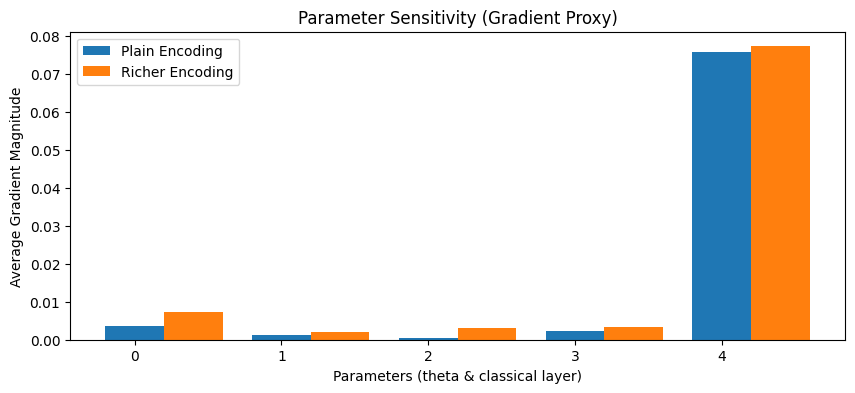

In [36]:
plt.figure(figsize=(10,4))

for i, (name, mdl) in enumerate(models.items()):
    mdl.train()  # Enable gradient computation for parameter sensitivity
    
    # Temporary optimizer for backward pass (not actually training)
    optimizer = torch.optim.Adam(mdl.parameters())
    optimizer.zero_grad()
    
    # Forward pass on the test set
    outputs = mdl(X_test)
    loss = criterion(outputs, y_test)
    
    # Backward pass to compute gradients
    loss.backward()
    
    # Collect average gradient magnitudes for each parameter
    grads = []
    for param in mdl.parameters():
        if param.requires_grad and param.grad is not None:
            grads.append(param.grad.detach().abs().mean().item())
    
    # Plot the average gradients for each parameter
    plt.bar(np.arange(len(grads)) + i*0.4, grads, width=0.4, label=name)

plt.xlabel("Parameters (theta & classical layer)")
plt.ylabel("Average Gradient Magnitude")
plt.title("Parameter Sensitivity (Gradient Proxy)")
plt.legend()
plt.show()

### 📉 Parameter Sensitivity: Knock-out & Cumulative Analysis

This section performs a "Knock-out" (Ablation) test to identify which parts of the model are most critical for performance.

**Method:**
1.  **Knock-out:** We iterate through every trainable parameter (quantum gates and classical weights), temporarily set it to **0.0**, and measure the **increase in Validation Loss ($\Delta L$)**.
2.  **Aggregation:** We sum these $\Delta L$ values by layer to see which parts of the architecture (Quantum Encoder vs. Classical Classifier) are doing the most work.

**Visualizations (2 Rows):**
* **Top Row (Top-K Parameters):** Shows the individual parameters that cause the biggest drop in performance when removed.
    * **Red Bars:** Quantum Parameters (Rotation angles).
    * **Blue Bars:** Classical Weights (Dense layer).
* **Bottom Row (Cumulative by Layer):** Aggregates the sensitivity.
    * If the **Quantum Layers** have high bars, the model is effectively using the quantum feature space.
    * If only the **Classical Output** has high bars, the quantum circuit might be acting as a passive identity map.



**Goal:**
We want to verify if the **Richer Encoding** actually relies on its deeper quantum circuit (high sensitivity in Quantum Layers) or if the heavy lifting is still done primarily by the classical output layer.

Running Knock-out Analysis for: Plain Encoding...
Running Knock-out Analysis for: Richer Encoding...


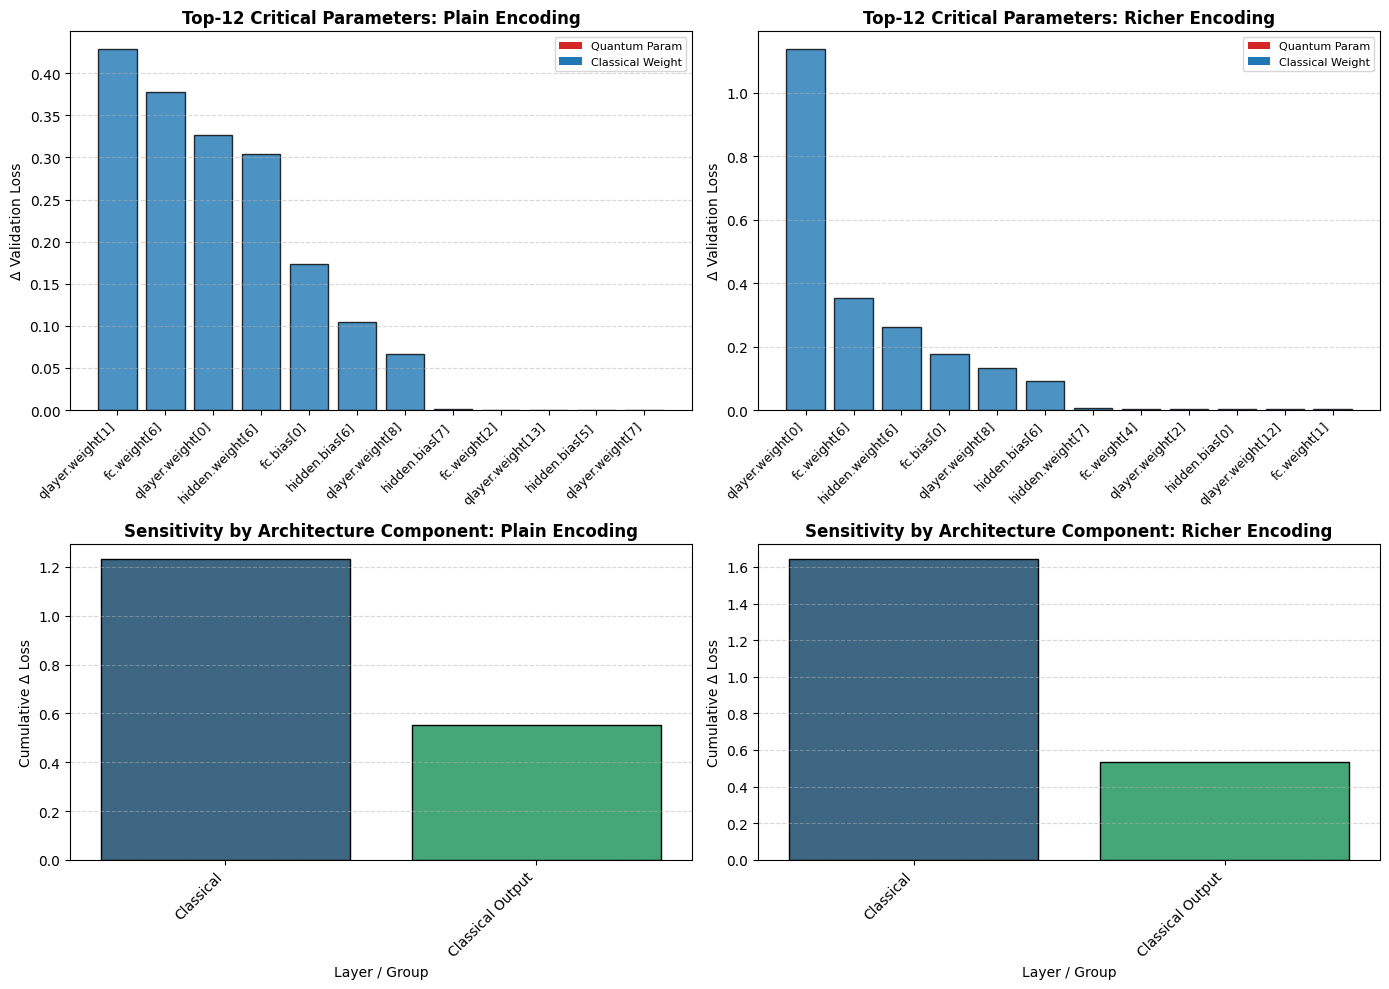

In [40]:
def analyze_parameter_knockout(model, X_data, y_data):
    """
    Performs 'Knock-out' analysis:
    Sets each trainable parameter to 0 individually and measures the increase in Loss.
    Returns a DataFrame with individual parameter results.
    """
    model.eval()
    criterion = torch.nn.BCEWithLogitsLoss()
    
    # 1. Compute Baseline Loss
    with torch.no_grad():
        base_preds = model(X_data)
        base_loss = criterion(base_preds, y_data).item()
        
    results = []
    
    # 2. Iterate over all named parameters
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
            
        # Flatten the parameter tensor to iterate element-wise
        param_flat = param.view(-1)
        original_values = param_flat.clone()
        
        for i in range(len(param_flat)):
            # --- A. Knock-out (Set to 0) ---
            val_backup = param_flat[i].item()
            with torch.no_grad():
                param_flat[i] = 0.0
            
            # --- B. Measure Loss ---
            with torch.no_grad():
                preds_ko = model(X_data)
                loss_ko = criterion(preds_ko, y_data).item()
                
            # --- C. Compute Delta (ReLU) ---
            # We ignore cases where loss improves (delta < 0)
            delta = max(0.0, loss_ko - base_loss)
            
            # --- D. Heuristic Labeling for Layers/Ops ---
            label = f"{name}[{i}]"
            group = "Classical"
            op_type = "Dense"
            
            # Heuristic for Quantum Weights (assuming 'q_params' or similar in Hybrid)
            if "q" in name.lower() and "weight" not in name.lower(): 
                # Assuming standard ansatz: params ordered by Layer -> Qubit
                n_qubits = 8 
                layer_idx = i // n_qubits
                qubit_idx = i % n_qubits
                label = f"Q_L{layer_idx}_q{qubit_idx}" # Layer, Qubit
                group = f"Quantum L{layer_idx}"
                op_type = "Rotation"
            
            # Heuristic for Classical Linear Layers
            elif "fc" in name or "linear" in name:
                group = "Classical Output"
                op_type = "Dense"
                
            results.append({
                "label": label,
                "group": group,
                "op_type": op_type,
                "delta": delta
            })
            
            # --- E. Restore ---
            with torch.no_grad():
                param_flat[i] = val_backup
            
    return pd.DataFrame(results)

# ---------------------------------------------------------
# Run Analysis on Both Models
# ---------------------------------------------------------
if 'models' not in locals():
    model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
    model_rich  = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)
    models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

import pandas as pd
import seaborn as sns

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1.2, 1])

for idx, (label, model_variant) in enumerate(models.items()):
    print(f"Running Knock-out Analysis for: {label}...")
    df_res = analyze_parameter_knockout(model_variant, X_test, y_test)
    
    # --- Plot 1: Top-K Individual Parameters (Top Row) ---
    ax_top = fig.add_subplot(gs[0, idx])
    
    K = 12
    top_df = df_res.sort_values("delta", ascending=False).head(K)
    
    # Color coding: Red for Quantum, Blue for Classical
    colors = ['#d62728' if 'Quantum' in g else '#1f77b4' for g in top_df['group']]
    
    ax_top.bar(range(K), top_df['delta'], color=colors, alpha=0.8, edgecolor='k')
    ax_top.set_xticks(range(K))
    ax_top.set_xticklabels(top_df['label'], rotation=45, ha='right', fontsize=9)
    ax_top.set_ylabel("Δ Validation Loss")
    ax_top.set_title(f"Top-{K} Critical Parameters: {label}", fontweight='bold')
    ax_top.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Legend for Top Row
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#d62728', label='Quantum Param'),
                       Patch(facecolor='#1f77b4', label='Classical Weight')]
    ax_top.legend(handles=legend_elements, loc='upper right', fontsize=8)

    # --- Plot 2: Cumulative Loss by Layer/Group (Bottom Row) ---
    ax_agg = fig.add_subplot(gs[1, idx])
    
    # Group by 'group' column and sum
    group_sums = df_res.groupby("group")["delta"].sum().sort_values(ascending=False)
    
    sns.barplot(
        x=group_sums.index, 
        y=group_sums.values, 
        hue=group_sums.index,      # Assign x variable to hue
        ax=ax_agg, 
        palette="viridis", 
        edgecolor='k',
        legend=False               # Disable legend
    )
    
    ax_agg.set_xticks(range(len(group_sums.index)))
    ax_agg.set_xticklabels(group_sums.index, rotation=45, ha='right')
    
    ax_agg.set_ylabel("Cumulative Δ Loss")
    ax_agg.set_xlabel("Layer / Group")
    ax_agg.set_title(f"Sensitivity by Architecture Component: {label}", fontweight='bold')
    ax_agg.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 📊 Wilcoxon Test: Feature Saliency Comparison

This section statistically compares the **feature saliency** between the **plain** and **richer encoding** models using the **Wilcoxon signed-rank test**:

- **Purpose:**  
  - Determine whether adding richer quantum encoding significantly changes the sensitivity of the model to each input feature.
  
- **Procedure:**  
  1. For each feature, extract saliency values (sensitivity) from both models.  
  2. Apply the Wilcoxon signed-rank test to check for differences between the paired distributions.  
  3. Mark features with `p < 0.05` as statistically significant (`*`).

- **Interpretation:**  
  - A significant result (`*`) suggests that the feature's influence on the model output differs between plain and richer encoding.

In [38]:
print("Wilcoxon Test: Plain vs Richer Encoding Feature Saliency\n")

for feature_idx, feature_name in enumerate(TOP_8_FEATS):
    plain_vals = saliency_plain[:, feature_idx]
    rich_vals  = saliency_rich[:, feature_idx]
    
    stat, p = wilcoxon(plain_vals, rich_vals, zero_method="pratt")
    
    sig = "*" if p < 0.05 else ""
    print(f"{feature_name:10}: stat={stat:.4f}, p={p:.4f} {sig}")

Wilcoxon Test: Plain vs Richer Encoding Feature Saliency

thal      : stat=310.0000, p=0.0001 *
cp        : stat=531.0000, p=0.0339 *
ca        : stat=542.0000, p=0.0413 *
exang     : stat=557.0000, p=0.0536 
oldpeak   : stat=303.0000, p=0.0001 *
chol      : stat=560.0000, p=0.0564 
thalach   : stat=350.0000, p=0.0006 *
slope     : stat=440.0000, p=0.0052 *
